In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from  pathlib import Path


In [2]:
from segmentation_utils.dataloader import (
    ImageCircleDatasetV2,
    ImageCircleDatasetSeperate,
)



/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
df = pd.read_excel("/home/tsakalis/ntua/phd/pronuclei_detector/data/whole_dna_tsakalis.xlsx")

In [4]:

df['embryo_id'] = df['Slide ID'] + "_"+df['Well'].astype(str)

In [5]:
pth_lib = Path('/media/tsakalis/STORAGE/phd/raw_timelapses')
pth_lib2 = Path("/home/tsakalis/ntua/phd/cellforge/cellforge/data/raw_timelapses")

In [6]:
def get_slide_ids(pth: Path) -> list[str]:
    return [(x.name, x) for x in list(pth.glob('*'))]



In [7]:
file_avail = pd.DataFrame(get_slide_ids(pth_lib)+get_slide_ids(pth_lib2), columns=['embryo_id', 'pth']).drop_duplicates(subset=['embryo_id'])

In [8]:
df['embryo_id'].sample(3)

219        D2017.07.18_S1600_I149_1
95     D2019.10.04_S02075_I0149_D_4
73     D2019.04.06_S01976_I0149_D_5
Name: embryo_id, dtype: object

In [9]:
file_avail.sample(1)

,embryo_id,pth
8617,D2012.01.10_S0154_I149_7,/media/tsakalis/STORAGE/phd/raw_timelapses/D20...


In [10]:
merged_df = pd.merge(df, file_avail,how='inner', on='embryo_id')

In [11]:
target_column = 'PGT RESULT'

In [12]:
merged_df['y'] = merged_df['Class_Grade'].fillna(0)

In [13]:
# merged_df[['y']+[target_column]].to_csv('targets.csv',index=False)

In [32]:
weights_pth = Path('/home/tsakalis/Desktop/final_pn_weights/multilabel_dpt-vit_base_patch16_224.augreg_in21k_3_classes_SEPARATE_MASK_FINAL.pt')

weights_pth_separate_df = Path('/home/tsakalis/Desktop/final_pn_weights/multiclass_dpt-vit_base_patch16_224.augreg_in21k_4_classes_whole_mask_FINAL.pt')

weights_pth_whole = Path('/home/tsakalis/Desktop/final_pn_weights/multiclass_dpt-vit_base_patch16_224.augreg_in21k_3_classes_WHOLE_SINGLE_MASK_FINAL.pt')

In [48]:
import segmentation_models_pytorch as smp
from tqdm import tqdm
from PIL import Image
import torch
import cv2
import numpy as np
from torch.utils.data import DataLoader
n_classes = 3
model_pronuclei = smp.DPT(
        encoder_name="tu-vit_base_patch16_224.augreg_in21k",
        encoder_weights="imagenet",
        in_channels=3,
        classes=n_classes,
    )

model_pronuclei.load_state_dict(
        torch.load(
          weights_pth,
            weights_only=True,
        )
    )


model_pronuclei_whole = smp.DPT(
        encoder_name="tu-vit_base_patch16_224.augreg_in21k",
        encoder_weights="imagenet",
        in_channels=3,
        classes=n_classes,
    )



model_name = "multiclass_dpt-vit_base_patch16_224.augreg_in21k_3_classes_WHOLE_SINGLE_MASK_FINAL"#"multiclass_u-mit_b5"
    # f"{type_of_problem}_{model_pronuclei.__dict__['name']}",
model_pronuclei_whole.load_state_dict(
    torch.load(
        f"/home/tsakalis/ntua/phd/cellforge/cellforge/model_weights/{model_name}.pt",
        weights_only=True,
    )
    )
model_pronuclei_separate = smp.DPT(
        encoder_name="tu-vit_base_patch16_224.augreg_in21k",
        encoder_weights="imagenet",
        in_channels=3,
        classes=4,
    )

model_pronuclei_separate.load_state_dict(
        torch.load(
          weights_pth_separate_df,
            weights_only=True,
        )
    )


<All keys matched successfully>

In [49]:
model_pronuclei.eval()

DPT(
  (encoder): TimmViTEncoder(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out

In [51]:
device='cuda'
model_pronuclei.to(device)

device='cuda'
model_pronuclei_whole.eval()
model_pronuclei_whole.to(device)

DPT(
  (encoder): TimmViTEncoder(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out

In [52]:
timesteps = Path('../../data/grade_timesteps.csv')

timesteps_df = pd.read_csv(timesteps)

In [53]:
timesteps_df

,id,dt
0,D2018.04.21_S01773_I0149_D_9,0.013425
1,D2018.04.21_S01773_I0149_D_9,0.024170
2,D2018.04.21_S01773_I0149_D_9,0.034594
3,D2018.04.21_S01773_I0149_D_9,0.045023
4,D2018.04.21_S01773_I0149_D_9,0.055439
...,...,...
1195354,D2016.02.08_S1220_I149_7,4.786479
1195355,D2016.02.08_S1220_I149_7,4.793438
1195356,D2016.02.08_S1220_I149_7,4.800382
1195357,D2016.02.08_S1220_I149_7,4.807327


In [54]:
timesteps_df.groupby('id').apply(lambda x: x.iloc[50:52].diff().iloc[1]).sort_values('dt').mean(
)

dt    0.009749
dtype: float64

In [55]:
from skimage.feature import graycomatrix, graycoprops


In [56]:
AVERAGE_TIMESTEP = 0.009 # hours/frame

In [57]:
import numpy as np
import cv2
from skimage.measure import label, regionprops
from skimage.feature import graycomatrix, graycoprops

from scipy.stats import skew, kurtosis

AVERAGE_TIMESTEP = 1.0  # or whatever your dt is

def extract_shape_geometry_features(img: np.ndarray):
    """
    Given a 2D uint8 array (binary mask), threshold at >0, find connected components,
    and return a dict of geometric features for the largest (or only) blob:
      - centroid (row, col)
      - area
      - filled_area
      - perimeter
      - bbox (min_row, min_col, max_row, max_col)
      - bounding_box_area
      - extent (area / bounding_box_area)
      - aspect_ratio (width/height)
      - equivalent_diameter
      - major_axis_length
      - minor_axis_length
      - orientation (radians)
      - convex_area
      - convex_hull_coords (Nx2 array of (row, col))
      - convex_perimeter
      - solidity (area / convex_area)
      - eccentricity (from regionprops)
      - euler_number
      - extent (area / bbox_area)
      - circularity (4π·area / perimeter²)
      - feret_diameter_max (maximum caliper distance via convex hull)
      - hu_moments (7,)
      - skeleton_length (# of pixels in skeleton)
      - endpoints (# of skeleton endpoints)
      - dt (average timestep between frames)
    """
    # 1) Binarize & label
    binary = img > 0
    labeled = label(binary)
    props = regionprops(labeled)

    # If no blobs at all, return a dict full of Nones
    if not props:
        return {
            'centroid_row': None,
            'centroid_col': None,
            'area': None,
            'filled_area': None,
            'perimeter': None,
            'bbox': None,
            'bounding_box_area': None,
            'extent': None,
            'aspect_ratio': None,
            'equivalent_diameter': None,
            'major_axis_length': None,
            'minor_axis_length': None,
            'orientation': None,
            'convex_area': None,
            'convex_hull': None,
            'convex_perimeter': None,
            'solidity': None,
            'eccentricity': None,
            'euler_number': None,
            'circularity': None,
            'feret_diameter_max': None,
            'hu_moments': None,
            'skeleton_length': None,
            'endpoints': None,
            'dt': AVERAGE_TIMESTEP
        }

    # Find the largest region by area (in case of multiple small blobs)
    region = max(props, key=lambda r: r.area)

    # If the largest blob is too small, treat as "no meaningful region"
    if region.area < 5:
        return {
            'centroid_row': None,
            'centroid_col': None,
            'area': None,
            'filled_area': None,
            'perimeter': None,
            'bbox': None,
            'bounding_box_area': None,
            'extent': None,
            'aspect_ratio': None,
            'equivalent_diameter': None,
            'major_axis_length': None,
            'minor_axis_length': None,
            'orientation': None,
            'convex_area': None,
            'convex_hull': None,
            'convex_perimeter': None,
            'solidity': None,
            'eccentricity': None,
            'euler_number': None,
            'circularity': None,
            'feret_diameter_max': None,
            'hu_moments': None,
            'skeleton_length': None,
            'endpoints': None,
            'dt': AVERAGE_TIMESTEP
        }

    # Basic shape features from regionprops
    area = region.area
    filled_area = region.filled_area
    perimeter = region.perimeter
    minr, minc, maxr, maxc = region.bbox
    height = maxr - minr
    width = maxc - minc
    bbox_area = width * height if (width > 0 and height > 0) else np.nan
    extent = area / bbox_area if bbox_area and not np.isnan(bbox_area) else np.nan
    aspect_ratio = width / float(height) if height > 0 else np.nan
    equiv_diameter = region.equivalent_diameter
    major_axis_length = region.major_axis_length
    minor_axis_length = region.minor_axis_length
    orientation = region.orientation  # in radians
    convex_area = region.convex_area
    eccentricity = region.eccentricity
    solidity = region.solidity  # area / convex_area
    euler_number = region.euler_number

    # Circularity: 4*pi*area / (perimeter^2)
    circularity = (4 * np.pi * area / (perimeter ** 2)) if perimeter > 0 else np.nan

    # Convex hull coords via OpenCV (to compute convex perimeter and Feret diameter)
    mask = region.image.astype(np.uint8)  # region-local mask
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    hull = cv2.convexHull(cnts[0])
    hull_pts = hull.squeeze()
    # Convert to global coordinates
    hull_global = np.column_stack([
        hull_pts[:, 1] + minr,  # row
        hull_pts[:, 0] + minc   # col
    ])
    # Convex perimeter (length of hull contour)
    convex_perimeter = cv2.arcLength(hull, True)
    # Compute maximum caliper distance (Feret diameter) from hull points
    # Brute‐force: pairwise distances
    if hull_pts.ndim == 2 and hull_pts.shape[0] > 1:
        # hull_pts are local coords [ [col, row], … ]
        pts = hull_pts[:, ::-1]  # convert to (row, col) if needed, but distances same regardless of ordering
        dists = np.sqrt(((pts[:, None, :] - pts[None, :, :]) ** 2).sum(axis=2))
        feret_diameter_max = np.nanmax(dists)
    else:
        feret_diameter_max = 0.0

    # Hu moments
    m = cv2.moments(mask)
    hu = cv2.HuMoments(m).flatten()

    # Skeletonize to compute skeleton length and endpoints
    from skimage.morphology import skeletonize, medial_axis
    from scipy import ndimage as ndi

    # skeleton (binary) of the region
    skeleton = skeletonize(mask > 0)
    skeleton_length = np.count_nonzero(skeleton)

    # Count endpoints: pixels in skeleton with only one neighbor
    # Compute neighbor count via convolution
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])
    neighbor_map = ndi.convolve(skeleton.astype(np.uint8), np.ones((3, 3)), mode='constant', cval=0)
    # For each skeleton pixel, count adjacent skeleton pixels
    endpoints = 0
    for (r, c), val in np.ndenumerate(skeleton):
        if val:
            # Count neighbors in 8‐connectivity
            nbr_count = np.sum(skeleton[max(r-1, 0):r+2, max(c-1, 0):c+2]) - 1
            if nbr_count == 1:
                endpoints += 1

    return {
        'centroid_row': float(region.centroid[0]),
        'centroid_col': float(region.centroid[1]),
        'area': area,
        'filled_area': filled_area,
        'perimeter': perimeter,
        'bbox': (minr, minc, maxr, maxc),
        'bounding_box_area': bbox_area,
        'extent': extent,
        'aspect_ratio': aspect_ratio,
        'equivalent_diameter': equiv_diameter,
        'major_axis_length': major_axis_length,
        'minor_axis_length': minor_axis_length,
        'orientation': orientation,
        'convex_area': convex_area,
        'convex_hull': hull_global,        # Nx2 array of (row, col)
        'convex_perimeter': convex_perimeter,
        'solidity': solidity,
        'eccentricity': eccentricity,
        'euler_number': euler_number,
        'circularity': circularity,
        'feret_diameter_max': feret_diameter_max,
        'hu_moments': hu,                  # length-7 array
        'skeleton_length': skeleton_length,
        'endpoints': endpoints,
        'dt': AVERAGE_TIMESTEP
    }


def extract_intensity_features(gray_img: np.ndarray, mask: np.ndarray, distances=[1], angles=[0]):
    """
    Given a 2D grayscale image and a binary mask (same dimensions), compute
    intensity-based features over the region where mask>0. Returns:
      - mean_intensity
      - median_intensity
      - std_intensity
      - min_intensity
      - max_intensity
      - skewness
      - kurtosis
      - entropy (Shannon)
      - percentiles (10th, 25th, 75th, 90th)
      - GLCM texture features: contrast, dissimilarity, homogeneity, ASM, energy, correlation
        (averaged over specified distances and angles)
      - dt (not meaningful here, but kept for consistency)
    """
    # Extract pixel values under mask
    pixels = gray_img[mask > 0].ravel().astype(np.float64)
    if pixels.size == 0:
        return {
            'mean_intensity': None,
            'median_intensity': None,
            'std_intensity': None,
            'min_intensity': None,
            'max_intensity': None,
            'skewness': None,
            'kurtosis': None,
            'entropy': None,
            'percentile_10': None,
            'percentile_25': None,
            'percentile_75': None,
            'percentile_90': None,
            'glcm_contrast': None,
            'glcm_dissimilarity': None,
            'glcm_homogeneity': None,
            'glcm_ASM': None,
            'glcm_energy': None,
            'glcm_correlation': None,
            'dt': None
        }

    # Basic statistics
    mean_intensity = float(np.mean(pixels))
    median_intensity = float(np.median(pixels))
    std_intensity = float(np.std(pixels))
    min_intensity = float(np.min(pixels))
    max_intensity = float(np.max(pixels))
    skewness = float(skew(pixels))
    kurt = float(kurtosis(pixels))

    # Shannon entropy over pixel histogram (256 bins)
    hist, _ = np.histogram(pixels, bins=256, range=(0, 255), density=True)
    # avoid log(0) by masking
    hist_nonzero = hist[hist > 0]
    entropy = float(-np.sum(hist_nonzero * np.log2(hist_nonzero)))

    # Percentiles
    p10 = float(np.percentile(pixels, 10))
    p25 = float(np.percentile(pixels, 25))
    p75 = float(np.percentile(pixels, 75))
    p90 = float(np.percentile(pixels, 90))

    # GLCM texture features: compute on masked region by cropping to bounding box
    coords = np.column_stack(np.where(mask > 0))
    minr, minc = coords.min(axis=0)
    maxr, maxc = coords.max(axis=0)
    roi = gray_img[minr:maxr+1, minc:maxc+1]
    roi_mask = mask[minr:maxr+1, minc:maxc+1]

    # Quantize ROI to 8 gray levels (0–7)
    roi_quant = np.floor(roi / 32).astype(np.uint8)
    roi_quant[roi_mask == 0] = 0  # force background to zero

    glcm = graycomatrix(
        roi_quant,
        distances=distances,
        angles=angles,
        levels=8,
        symmetric=True,
        normed=True
    )

    contrast = float(np.mean(graycoprops(glcm, 'contrast')))
    dissimilarity = float(np.mean(graycoprops(glcm, 'dissimilarity')))
    homogeneity = float(np.mean(graycoprops(glcm, 'homogeneity')))
    ASM = float(np.mean(graycoprops(glcm, 'ASM')))
    energy = float(np.mean(graycoprops(glcm, 'energy')))
    correlation = float(np.mean(graycoprops(glcm, 'correlation')))

    return {
        'mean_intensity': mean_intensity,
        'median_intensity': median_intensity,
        'std_intensity': std_intensity,
        'min_intensity': min_intensity,
        'max_intensity': max_intensity,
        'skewness': skewness,
        'kurtosis': kurt,
        'entropy': entropy,
        'percentile_10': p10,
        'percentile_25': p25,
        'percentile_75': p75,
        'percentile_90': p90,
        'glcm_contrast': contrast,
        'glcm_dissimilarity': dissimilarity,
        'glcm_homogeneity': homogeneity,
        'glcm_ASM': ASM,
        'glcm_energy': energy,
        'glcm_correlation': correlation,
        'dt': AVERAGE_TIMESTEP
    }


In [269]:
from typing import Any
def inference_whole_slide(model, slide_pth: Path, max_frame: int, whole_model: Any| None = None):

    image_file_paths = sorted(list(slide_pth.glob("*.jpg")), key=lambda x: int(x.stem))[
        :max_frame
    ]

    images = [Image.open(img_path) for img_path in tqdm(image_file_paths)]

    val_dataset = ImageCircleDatasetV2(images, images, images, images, predict=True)

    val_dataloader = DataLoader(val_dataset, batch_size=32)

    model.eval()
    from torch.cuda.amp import autocast

    all_masks = []


    all_whole_masks = []
    for inpt_images, _ in val_dataloader:
        with torch.no_grad():
            # with autocast():

            pred_mask = model(inpt_images.to(device))
            #
            # masks = torch.softmax(pred_mask,axis=1).cpu().numpy()>0.05
            
            masks = torch.sigmoid(pred_mask).cpu().numpy()

            if whole_model:
                pred_mask = whole_model(inpt_images.to(device))
                mask_whole = torch.softmax(pred_mask,axis=1).cpu().numpy()[:,1,:,:]
                all_whole_masks.extend([msk for msk in mask_whole])
                # masks[...,0]+masks_whole

            
            all_masks.extend([msk for msk in masks])
            # breakpoint()

    pn_size = []
    final_images = []
    upscaled_masks = []
    isolated_pns = []
    counter = 0
    for pil_img, mask in zip(images[:], all_masks[:]):
        # Ensure the mask is 2D by removing extra dimensions
        # pil_img = pil_img.resize((224, 224), Image.Resampling.LANCZOS)
        if len(all_whole_masks)>0:
            whole_mask = all_whole_masks[counter]
            pn_mask_1 = ((mask[0]+whole_mask)/2)>0.5

            pn_mask_2 = ((mask[1]+whole_mask)/2)>0.5
        else:
            whole_mask = mask[0]>0.7

            pn_mask_1 = mask[0]>0.7

            pn_mask_2 = mask[1]>0.7

        image_ar = np.stack(3 * [np.array(pil_img)])


        

        upscaled_mask1 = cv2.resize(
            pn_mask_1.astype(np.uint8), (500, 500), interpolation=cv2.INTER_NEAREST
        )
        upscaled_mask2 = cv2.resize(
            pn_mask_2.astype(np.uint8), (500, 500), interpolation=cv2.INTER_NEAREST
        )
        upscaled_mask3 = cv2.resize(
            mask[2].astype(np.uint8), (500, 500), interpolation=cv2.INTER_NEAREST
        )

        # pn_size.append(upscaled_mask.sum())

        upscaled_masks.append((upscaled_mask1, upscaled_mask2, upscaled_mask3))
        image_pn_isolated = image_ar.copy()
        image_pn_isolated[:, ~upscaled_mask1.astype(bool)] = 0
        isolated_pns.append(image_pn_isolated.transpose(1, 2, 0))
        # image_ar[0, upscaled_mask1.astype(bool)] = 1
        # image_ar[1, upscaled_mask2.astype(bool)] = 1
        # image_ar[2, upscaled_mask3.astype(bool)] = 1

        final_images.append(Image.fromarray(image_ar.transpose(1, 2, 0)))
        counter+=1

    return (
        final_images,
        upscaled_masks,
    )


In [285]:

pn1_features_all =[]
pn2_features_all = []

pn1_features_intens =[]
pn2_features_intens = []
whole_emb_all = []
for slide_path in  merged_df['pth'].dropna().tolist():

    images, masks = inference_whole_slide(model_pronuclei,slide_path,130, model_pronuclei_whole)
    pn1_features = pd.DataFrame([extract_shape_geometry_features(msk[0]) for msk in masks])
    pn2_features = pd.DataFrame([extract_shape_geometry_features(msk[1]) for msk in masks])

    pn1_intensity_features = pd.DataFrame([extract_intensity_features(np.array(img)[...,0], msk[0]) for img, msk in zip(images,masks)])
    pn2_intensity_features = pd.DataFrame([extract_intensity_features(np.array(img)[...,0], msk[1]) for img, msk in zip(images,masks)])
    
    whole_emb = pd.DataFrame([extract_shape_geometry_features(msk[2]) for msk in masks])

    pn1_features['embryo_id'] = slide_path.name
    pn2_features['embryo_id'] = slide_path.name
    whole_emb['embryo_id'] = slide_path.name

    pn1_intensity_features['embryo_id'] = slide_path.name

    pn2_intensity_features['embryo_id'] = slide_path.name
    pn1_features_all.append(pn1_features)
    pn2_features_all.append(pn2_features)

    pn1_features_intens.append(pn1_intensity_features)
    pn2_features_intens.append(pn2_intensity_features)


    whole_emb_all.append(whole_emb)
    # break





100%|██████████| 130/130 [00:00<00:00, 59859.43it/s]
/home/tsakalis/ntua/phd/pronuclei_detector/src/segmentation_utils/dataloader.py:533: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),
100%|██████████| 130/130 [00:00<00:00, 71052.84it/s]
/home/tsakalis/ntua/phd/pronuclei_detector/src/segmentation_utils/dataloader.py:533: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),
100%|██████████| 130/130 [00:00<00:00, 71471.95it/s]
/home/tsakalis/ntua/phd/pronuclei_detector/src/segmentation_utils/dataloader.py:533: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.2, alpha=1, sigma=50, alpha_affine=50),
100%|██████████| 130/130 [00:00<00:00, 67224.70it/s]
/home/tsakalis/ntua/phd/pronuclei_detector/src/segmentation_utils/dataloader.py:533

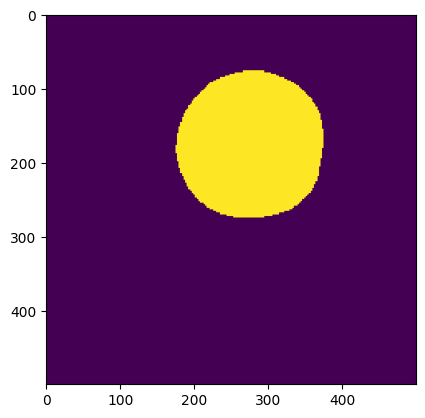

In [286]:
import matplotlib.pyplot as plt
plt.imshow(masks[60][2])

In [287]:
full_pn1_df = pd.concat(pn1_features_all).reset_index()
full_pn2_df = pd.concat(pn2_features_all).reset_index()



full_pn1_intens_df = pd.concat(pn1_features_intens).reset_index()
full_pn2_intens_df = pd.concat(pn2_features_intens).reset_index()
whole_emb_all_df = pd.concat(whole_emb_all).reset_index()

full_pn1_df['time'] = full_pn1_df['dt'].cumsum()
full_pn2_df['time'] = full_pn2_df['dt'].cumsum()

full_pn1_intens_df['time'] = full_pn1_intens_df['dt'].cumsum()
full_pn2_intens_df['time'] = full_pn2_intens_df['dt'].cumsum()

whole_emb_all_df['time'] = whole_emb_all_df['dt'].cumsum()

/tmp/ipykernel_3841974/3220517177.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_pn1_df = pd.concat(pn1_features_all).reset_index()
/tmp/ipykernel_3841974/3220517177.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_pn2_df = pd.concat(pn2_features_all).reset_index()
/tmp/ipykernel_3841974/3220517177.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when

<Axes: >

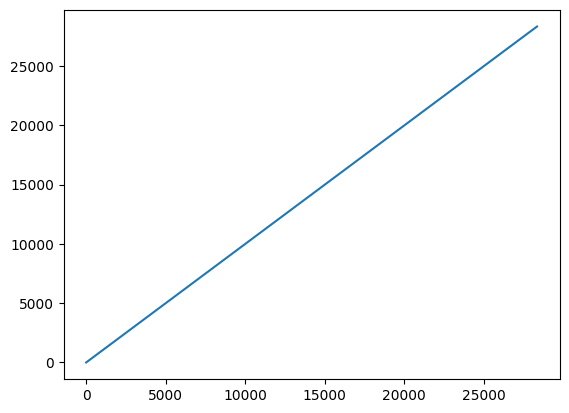

In [288]:
full_pn1_df['time'] .plot()

In [289]:
full_pn1_df['time'] = full_pn1_df.groupby('embryo_id')['dt'].cumsum()
full_pn2_df['time'] = full_pn2_df.groupby('embryo_id')['dt'].cumsum()

full_pn1_intens_df['time'] = full_pn1_intens_df.groupby('embryo_id')['dt'].cumsum()
full_pn2_intens_df['time'] = full_pn2_intens_df.groupby('embryo_id')['dt'].cumsum()

whole_emb_all_df['time'] = whole_emb_all_df.groupby('embryo_id')['dt'].cumsum()


In [290]:
full_pn1_df

,index,centroid_row,centroid_col,area,filled_area,perimeter,bbox,bounding_box_area,extent,aspect_ratio,...,eccentricity,euler_number,circularity,feret_diameter_max,hu_moments,skeleton_length,endpoints,dt,embryo_id,time
0,0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,1.0,D2017.06.02_S1566_I149_2,1.0
1,1,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,1.0,D2017.06.02_S1566_I149_2,2.0
2,2,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,1.0,D2017.06.02_S1566_I149_2,3.0
3,3,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,1.0,D2017.06.02_S1566_I149_2,4.0
4,4,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,1.0,D2017.06.02_S1566_I149_2,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28335,125,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,1.0,D2018.03.26_S01756_I0149_D_7,126.0
28336,126,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,1.0,D2018.03.26_S01756_I0149_D_7,127.0
28337,127,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,1.0,D2018.03.26_S01756_I0149_D_7,128.0
28338,128,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,1.0,D2018.03.26_S01756_I0149_D_7,129.0


In [291]:
simple_features = ['area', 'perimeter', 'eccentricity', 'solidity']

<Axes: >

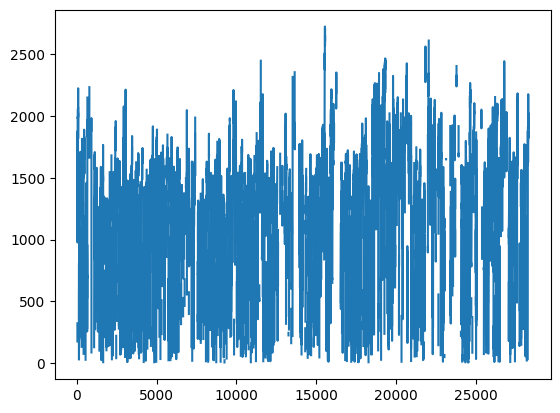

In [292]:
full_pn1_df['area'].apply(lambda x: np.mean(x)).plot()

<Axes: >

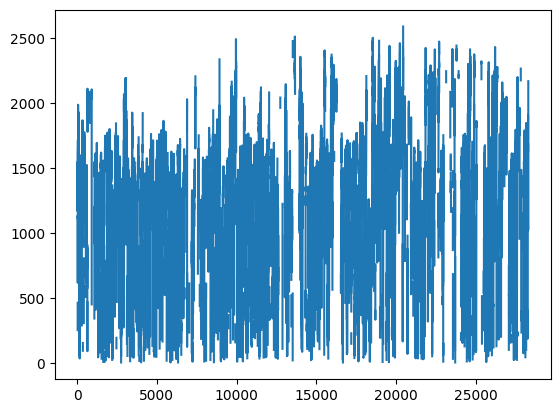

In [293]:
full_pn2_df['area'].apply(lambda x: np.mean(x)).plot()

In [294]:

def find_signal(arr: np.ndarray[bool]):
    # Find the largest continuous block of ones
    max_len = 0
    max_start = 0
    curr_len = 0
    curr_start = 0
    for i in range(len(arr)):
        if arr[i] == 1:
            if curr_len == 0:
                curr_start = i
            curr_len += 1
        else:
            if curr_len > max_len:
                max_len = curr_len
                max_start = curr_start
            curr_len = 0
    # Check at the end in case the longest sequence is at the end
    if curr_len > max_len:
        max_len = curr_len
        max_start = curr_start
    return max_start, max_len

In [295]:
import numpy as np

def find_continuous_region(signal):
    nonzero_indices = np.nonzero(signal)[0]
    if nonzero_indices.size == 0:
        return None  # No non-zero region found
    start_idx = nonzero_indices[0]
    end_idx = nonzero_indices[-1]
    return start_idx, end_idx


In [457]:
full_pn1_intens_df.columns

Index(['index', 'mean_intensity', 'median_intensity', 'std_intensity',
       'min_intensity', 'max_intensity', 'skewness', 'kurtosis', 'entropy',
       'percentile_10', 'percentile_25', 'percentile_75', 'percentile_90',
       'glcm_contrast', 'glcm_dissimilarity', 'glcm_homogeneity', 'glcm_ASM',
       'glcm_energy', 'glcm_correlation', 'dt', 'embryo_id', 'time'],
      dtype='object')

In [296]:
import matplotlib.pyplot as plt

In [297]:
from scipy import signal

In [298]:
import numpy as np
def crosscorr(s1, s2):
    s1 = s1 - np.mean(s1)
    s2 = s2 - np.mean(s2)
    corr = np.correlate(s1, s2, mode='full')
    lag = np.argmax(corr) - (len(s2) - 1)
    max_corr = np.max(corr) / (np.std(s1) * np.std(s2) * len(s1))
    return max_corr, lag

In [542]:
AVERAGE_TIMESTEP = 0.009

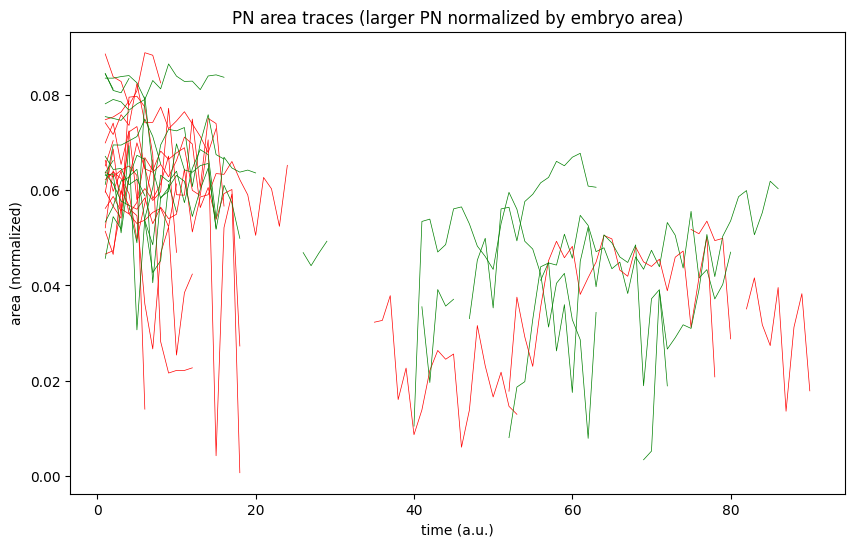

In [576]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

def find_signal(mask: np.ndarray):
    """Return (start_idx, length) of the longest contiguous True stretch in *mask*."""
    best_start = 0
    best_len = 0
    cur_start = None
    cur_len = 0
    for idx, flag in enumerate(mask):
        if flag:
            if cur_start is None:
                cur_start = idx
                cur_len = 1
            else:
                cur_len += 1
            if cur_len > best_len:
                best_start = cur_start
                best_len = cur_len
        else:
            cur_start = None
            cur_len = 0
    return best_start, best_len

records = []
plt.figure(figsize=(10, 6))

avoid_ids = []

for embryo_id in merged_df.dropna(subset=['Class_Grade'])["embryo_id"].to_list():
    try:
        # Pull PN1 track
        g1 = (
            full_pn1_df[full_pn1_df["embryo_id"] == embryo_id]
            .copy()
            .reset_index(drop=True)
        )
        g1["area"] = g1["area"].fillna(1)
        g1["time"] = g1["dt"].cumsum()
        start1, len1 = find_signal(g1["area"].values != 1)
        pn1 = g1.iloc[start1 : start1 + len1].reset_index(drop=True)

        if np.abs(pn1['time'].max()-pn1['time'].min())>30:

            # avoid_ids.append(embryo_id)
            continue

        # Pull PN2 track
        g2 = (
            full_pn2_df[full_pn2_df["embryo_id"] == embryo_id]
            .copy()
            .reset_index(drop=True)
        )
        g2["area"] = g2["area"].fillna(1)
        g2["time"] = g2["dt"].cumsum()
        start2, len2 = find_signal(g2["area"].values != 1)
        pn2 = g2.iloc[start2 : start2 + len2].reset_index(drop=True)

        # Skip if missing PN tracks
        if pn1.empty or pn2.empty:
            continue

        # Label PN1 as the larger pronucleus, PN2 as the smaller
        if pn1["area"].max() < pn2["area"].max():
            first_pn, second_pn = pn2, pn1
            first_start, first_len = start2, len2
            second_start, second_len = start1, len1
        else:
            first_pn, second_pn = pn1, pn2
            first_start, first_len = start1, len1
            second_start, second_len = start2, len2

        # Prepare whole-embryo track with time
        whole_emb = (
            whole_emb_all_df[whole_emb_all_df["embryo_id"] == embryo_id]
            .copy()
            .reset_index(drop=True)
        )
        whole_emb["time"] = whole_emb["dt"].cumsum()

        # Slices of whole embryo corresponding to each PN interval
        whole_emb_slice1 = (
            whole_emb.iloc[first_start : first_start + first_len]
            .reset_index(drop=True)
        )
        whole_emb_slice2 = (
            whole_emb.iloc[second_start : second_start + second_len]
            .reset_index(drop=True)
        )

        # Compute area-based features for each PN
        area1 = first_pn["area"].values / whole_emb_slice1["area"].mean()
        area2 = second_pn["area"].values / whole_emb_slice2["area"].mean()
        t1 = first_pn["time"].values
        t2 = second_pn["time"].values

        auc1 = np.nansum(area1)
        auc2 = np.nansum(area2)
        max_area1 = np.nanmax(area1) if area1.size > 0 else np.nan
        max_area2 = np.nanmax(area2) if area2.size > 0 else np.nan
        mean_area1 = np.nanmean(area1) if area1.size > 0 else np.nan
        mean_area2 = np.nanmean(area2) if area2.size > 0 else np.nan
        area_ratio = max_area1 / max_area2 if (max_area2 and not np.isnan(max_area2)) else np.nan
        area_diff = max_area1 - max_area2
        min_area = min(max_area1, max_area2)

        # Appearance and disappearance times
        start_time1 = t1[0] if t1.size > 0 else np.nan
        start_time2 = t2[0] if t2.size > 0 else np.nan
        end_time1 = t1[-1] if t1.size > 0 else np.nan
        end_time2 = t2[-1] if t2.size > 0 else np.nan
        appearance_diff = start_time2 - start_time1
        disappearance_diff = end_time2 - end_time1

        # Overlap duration
        overlap_start = max(start_time1, start_time2)
        overlap_end = min(end_time1, end_time2)
        overlap_duration = overlap_end - overlap_start if overlap_end > overlap_start else 0.0

        # Time to reach max area and growth rates
        idx_max1 = np.nanargmax(area1) if area1.size > 0 else None
        idx_max2 = np.nanargmax(area2) if area2.size > 0 else None
        t_max1 = t1[idx_max1] if idx_max1 is not None else np.nan
        t_max2 = t2[idx_max2] if idx_max2 is not None else np.nan
        growth_rate1 = (
            (max_area1 - area1[0]) / (t_max1 - start_time1)
            if (area1.size > 1 and (t_max1 - start_time1) > 0)
            else np.nan
        )
        growth_rate2 = (
            (max_area2 - area2[0]) / (t_max2 - start_time2)
            if (area2.size > 1 and (t_max2 - start_time2) > 0)
            else np.nan
        )

        # Distance PN-to-embryo centroid (mean) for each PN
        df1 = first_pn[["time", "centroid_col", "centroid_row"]]
        df_emb1 = whole_emb_slice1[["time", "centroid_col", "centroid_row"]].rename(columns={"centroid_col": "emb_x", "centroid_row": "emb_y"})
        merge1 = pd.merge(df1, df_emb1, on="time", how="inner")
        distances1 = np.hypot(merge1["centroid_col"].values - merge1["emb_x"].values, merge1["centroid_row"].values - merge1["emb_y"].values)
        mean_dist1 = np.nanmean(distances1) if distances1.size > 0 else np.nan

        df2 = second_pn[["time", "centroid_col", "centroid_row"]]
        df_emb2 = whole_emb_slice2[["time", "centroid_col", "centroid_row"]].rename(columns={"centroid_col": "emb_x", "centroid_row": "emb_y"})
        merge2 = pd.merge(df2, df_emb2, on="time", how="inner")
        distances2 = np.hypot(merge2["centroid_col"].values - merge2["emb_x"].values, merge2["centroid_row"].values - merge2["emb_y"].values)
        mean_dist2 = np.nanmean(distances2) if distances2.size > 0 else np.nan

        # Pronuclear pair features: align PN1 and PN2 by time
        df_pn1 = first_pn[["time", "centroid_col", "centroid_row", "area"]].rename(columns={"centroid_col": "x1", "centroid_row": "y1", "area": "area1"})
        df_pn2 = second_pn[["time", "centroid_col", "centroid_row", "area"]].rename(columns={"centroid_col": "x2", "centroid_row": "y2", "area": "area2"})
        df_overlap = pd.merge(df_pn1, df_pn2, on="time", how="inner")

        if not df_overlap.empty:
            # Distances between PN centroids
            pn_distances = np.hypot(df_overlap["x1"].values - df_overlap["x2"].values,
                                     df_overlap["y1"].values - df_overlap["y2"].values)
            avg_pn_distance = np.nanmean(pn_distances)
            min_pn_distance = np.nanmin(pn_distances)
            final_pn_distance = pn_distances[-1]

            # Distance between PN midpoint and embryo center (mean over overlap)
            df_emb_full = whole_emb[["time", "centroid_col", "centroid_row"]].rename(columns={"centroid_col": "emb_x", "centroid_row": "emb_y"})
            df_mid = df_overlap.copy()
            df_mid["mid_x"] = (df_mid["x1"] + df_mid["x2"]) / 2
            df_mid["mid_y"] = (df_mid["y1"] + df_mid["y2"]) / 2
            df_mid = pd.merge(df_mid, df_emb_full, on="time", how="inner")
            midpoint_distances = np.hypot(df_mid["mid_x"].values - df_mid["emb_x"].values,
                                          df_mid["mid_y"].values - df_mid["emb_y"].values)
            mean_midpoint_dist = np.nanmean(midpoint_distances)

            # Correlation of area trajectories during overlap
            if df_overlap["area1"].nunique() > 1 and df_overlap["area2"].nunique() > 1:
                corr_matrix = np.corrcoef(df_overlap["area1"].values, df_overlap["area2"].values)
                area_correlation = corr_matrix[0, 1]
            else:
                area_correlation = np.nan

            # Rate of convergence: linear fit of distance vs time
            times_ov = df_overlap["time"].values
            if pn_distances.size > 1 and np.ptp(times_ov) > 0:
                slope, _ = np.polyfit(times_ov, pn_distances, 1)
                convergence_rate = slope  # distance per time
            else:
                convergence_rate = np.nan

            # PN‐meeting time: first time PN distance ≤ 15% of embryo diameter
            # Estimate embryo diameter from whole-embryo area at the first overlap frame
            emb_area0 = whole_emb.loc[whole_emb["time"] == times_ov[0], "area"].iloc[0]
            emb_diameter = 2 * np.sqrt(emb_area0 / np.pi)
            threshold = 0.15 * emb_diameter
            below_thresh = (pn_distances <= threshold)
            pn_meeting_time = times_ov[np.argmax(below_thresh)] if below_thresh.any() else np.nan
        else:
            avg_pn_distance = np.nan
            min_pn_distance = np.nan
            final_pn_distance = np.nan
            mean_midpoint_dist = np.nan
            area_correlation = np.nan
            convergence_rate = np.nan
            pn_meeting_time = np.nan

        # Build record
        record = {
            "embryo_id": embryo_id,
            # Existing features
            "eccentricity1": mean_dist1,
            "eccentricity2": mean_dist2,
            "lifetime1": end_time1 - start_time1 if not np.isnan(end_time1 - start_time1) else np.nan,
            "lifetime2": end_time2 - start_time2 if not np.isnan(end_time2 - start_time2) else np.nan,
            # Area-based features
            "auc1": auc1,
            "auc2": auc2,
            "max_area1": max_area1,
            "max_area2": max_area2,
            "mean_area1": mean_area1,
            "mean_area2": mean_area2,
            "area_ratio": area_ratio,
            "area_diff": area_diff,
            "min_area": min_area,
            # Temporal features
            "start_time1": start_time1,
            "start_time2": start_time2,
            "appearance_diff": appearance_diff,
            "end_time1": end_time1,
            "end_time2": end_time2,
            "disappearance_diff": disappearance_diff,
            "overlap_duration": overlap_duration,
            "growth_rate1": growth_rate1,
            "growth_rate2": growth_rate2,
            "async_start": abs(start_time1-start_time2),
            "async_fade": abs(end_time1-end_time2),
            # Spatial relationship features
            "avg_pn_distance": avg_pn_distance,
            "min_pn_distance": min_pn_distance,
            "final_pn_distance": final_pn_distance,
            "mean_midpoint_dist": mean_midpoint_dist,
            # Dynamic relationship features
            "area_correlation": area_correlation,
            "convergence_rate": convergence_rate,
            # New feature: PN‐meeting time
            "pn_meeting_time": pn_meeting_time,
            # Label
            "target": (
                merged_df.loc[merged_df["embryo_id"] == embryo_id, "y"].values[0]
            ),
        }
        records.append(record)

        # Optional visualization: area trace of the larger pronucleus
        label_good = record["target"]

        # if (first_pn["time"].max()-first_pn["time"].min())>0.4:
        # if merged_df.loc[merged_df["embryo_id"] == embryo_id, "y"].values[0]>1:
        plt.plot(
            first_pn["time"],
            first_pn["area"] / whole_emb_slice1["area"].mean(),
            lw=0.5,
            color="green" if label_good else "red",
        )

        

    except Exception as exc:
        print(f"{embryo_id}: {exc}")

# Assemble results
features_df = pd.DataFrame(records)

plt.xlabel("time (a.u.)")
plt.ylabel("area (normalized)")
plt.title("PN area traces (larger PN normalized by embryo area)")
plt.show()

df_metrics = features_df.copy()


In [577]:
df_metrics.shape

(41, 33)

In [578]:
merged_df['y'].value_counts()/merged_df['y'].shape

y
0.0    0.605505
2.0    0.325688
1.0    0.068807
Name: count, dtype: float64

In [579]:
df_metrics['target'].value_counts()/df_metrics['target'].shape[0]

target
0.0    0.487805
2.0    0.463415
1.0    0.048780
Name: count, dtype: float64

In [580]:
df_metrics['target'].value_counts()/df_metrics['target'].shape[0]

target
0.0    0.487805
2.0    0.463415
1.0    0.048780
Name: count, dtype: float64

In [487]:
import numpy as np
import pandas as pd

def find_signal(mask: np.ndarray):
    """Return (start_idx, length) of the longest contiguous True stretch in *mask*."""
    best_start = 0
    best_len = 0
    cur_start = None
    cur_len = 0
    for idx, flag in enumerate(mask):
        if flag:
            if cur_start is None:
                cur_start = idx
                cur_len = 1
            else:
                cur_len += 1
            if cur_len > best_len:
                best_start = cur_start
                best_len = cur_len
        else:
            cur_start = None
            cur_len = 0
    return best_start, best_len

records = []

for embryo_id in merged_df.dropna(subset=["Class_Grade"])["embryo_id"].to_list():
    try:
        # PN1 intensity track
        g1 = (
            full_pn1_intens_df[full_pn1_intens_df["embryo_id"] == embryo_id]
            .copy()
            .reset_index(drop=True)
        )
        g1["time"] = g1["dt"].cumsum()
        mask1 = ~g1["median_intensity"].isna()
        start1, len1 = find_signal(mask1.values)
        pn1 = g1.iloc[start1 : start1 + len1].reset_index(drop=True)
        if pn1.empty or (pn1["time"].max() - pn1["time"].min()) < 20:
            continue

        # PN2 intensity track
        g2 = (
            full_pn2_intens_df[full_pn2_intens_df["embryo_id"] == embryo_id]
            .copy()
            .reset_index(drop=True)
        )
        g2["time"] = g2["dt"].cumsum()
        mask2 = ~g2["median_intensity"].isna()
        start2, len2 = find_signal(mask2.values)
        pn2 = g2.iloc[start2 : start2 + len2].reset_index(drop=True)
        if pn2.empty:
            continue

        # Label larger vs. smaller PN by peak median_intensity
        peak1 = pn1["median_intensity"].max() if not pn1["median_intensity"].isna().all() else np.nan
        peak2 = pn2["median_intensity"].max() if not pn2["median_intensity"].isna().all() else np.nan
        if peak2 > peak1:
            first_pn, second_pn = pn2, pn1
            first_start, first_len = start2, len2
            second_start, second_len = start1, len1
        else:
            first_pn, second_pn = pn1, pn2
            first_start, first_len = start1, len1
            second_start, second_len = start2, len2

        # Compute intensity‐based features for a given PN DataFrame
        def compute_intensity_features(pn_df, prefix):
            arr_mean = pn_df["mean_intensity"].values
            arr_med = pn_df["median_intensity"].values
            arr_std = pn_df["std_intensity"].values
            t = pn_df["time"].values

            auc_mean = np.nansum(arr_mean)
            auc_med = np.nansum(arr_med)
            max_mean = np.nanmax(arr_mean) if arr_mean.size > 0 else np.nan
            max_med = np.nanmax(arr_med) if arr_med.size > 0 else np.nan
            mean_mean = np.nanmean(arr_mean) if arr_mean.size > 0 else np.nan
            mean_med = np.nanmean(arr_med) if arr_med.size > 0 else np.nan

            start_time = t[0] if t.size > 0 else np.nan
            end_time = t[-1] if t.size > 0 else np.nan

            idx_peak = np.nanargmax(arr_med) if arr_med.size > 0 else None
            t_peak = t[idx_peak] if idx_peak is not None else np.nan
            growth_med = (
                (max_med - arr_med[0]) / (t_peak - start_time)
                if (arr_med.size > 1 and (t_peak - start_time) > 0)
                else np.nan
            )

            return {
                f"{prefix}_auc_mean": auc_mean,
                f"{prefix}_auc_med": auc_med,
                f"{prefix}_max_mean": max_mean,
                f"{prefix}_max_med": max_med,
                f"{prefix}_mean_mean": mean_mean,
                f"{prefix}_mean_med": mean_med,
                f"{prefix}_start_time": start_time,
                f"{prefix}_end_time": end_time,
                f"{prefix}_growth_med": growth_med,
                f"{prefix}_std_mean": np.nanmean(arr_std) if arr_std.size > 0 else np.nan,
                f"{prefix}_skew_med": pn_df["skewness"].mean() if "skewness" in pn_df else np.nan,
                f"{prefix}_kurt_med": pn_df["kurtosis"].mean() if "kurtosis" in pn_df else np.nan,
                f"{prefix}_entropy": pn_df["entropy"].mean() if "entropy" in pn_df else np.nan,
                f"{prefix}_p10": pn_df["percentile_10"].mean() if "percentile_10" in pn_df else np.nan,
                f"{prefix}_p25": pn_df["percentile_25"].mean() if "percentile_25" in pn_df else np.nan,
                f"{prefix}_p75": pn_df["percentile_75"].mean() if "percentile_75" in pn_df else np.nan,
                f"{prefix}_p90": pn_df["percentile_90"].mean() if "percentile_90" in pn_df else np.nan,
            }

        feats1 = compute_intensity_features(first_pn, "pn1")
        feats2 = compute_intensity_features(second_pn, "pn2")

        # Pairwise features
        start1 = feats1["pn1_start_time"]
        start2 = feats2["pn2_start_time"]
        end1 = feats1["pn1_end_time"]
        end2 = feats2["pn2_end_time"]

        appearance_diff = start2 - start1
        disappearance_diff = end2 - end1
        overlap_start = max(start1, start2)
        overlap_end = min(end1, end2)
        overlap_dur = overlap_end - overlap_start if overlap_end > overlap_start else 0.0

        df1 = first_pn[["time", "median_intensity"]].rename(columns={"median_intensity": "med1"})
        df2 = second_pn[["time", "median_intensity"]].rename(columns={"median_intensity": "med2"})
        df_ov = pd.merge(df1, df2, on="time", how="inner")
        if not df_ov.empty and df_ov["med1"].nunique() > 1 and df_ov["med2"].nunique() > 1:
            corr = np.corrcoef(df_ov["med1"].values, df_ov["med2"].values)[0, 1]
        else:
            corr = np.nan

        record = {
            "embryo_id": embryo_id,
            "appearance_diff": appearance_diff,
            "disappearance_diff": disappearance_diff,
            "overlap_duration": overlap_dur,
            "median_corr": corr,
            "target": merged_df.loc[merged_df["embryo_id"] == embryo_id, "y"].values[0],
        }
        record.update(feats1)
        record.update(feats2)
        records.append(record)

    except Exception as exc:
        print(f"{embryo_id}: {exc}")

intensity_features_df = pd.DataFrame(records)


In [488]:
from scipy.stats import mannwhitneyu

pos_group = intensity_features_df.loc[intensity_features_df['target']>0]
neg_group = intensity_features_df.loc[intensity_features_df['target']==0]

relevant_cols = []
for col in intensity_features_df.columns[1:]:
    if col=='target':
        continue




    res = mannwhitneyu(pos_group[col].fillna(0), neg_group[col].fillna(0))#
    # res  =pointbiserialr(df_metrics['target'], df_metrics[col].fillna(df_metrics[col].mean()))

    print(f"==== {col}")
    print(res.pvalue)
    if res.pvalue<0.05:
        print(res.statistic)
        relevant_cols.append(col)
    
    

==== appearance_diff
0.9600236714687848
==== disappearance_diff
0.3639052290864633
==== overlap_duration
0.742643758308507
==== median_corr
0.7842495069868667
==== pn1_auc_mean
0.43743848751530023
==== pn1_auc_med
0.4299161600076853
==== pn1_max_mean
0.22184853615500066
==== pn1_max_med
0.22049980245910517
==== pn1_mean_mean
0.11551841849941377
==== pn1_mean_med
0.12311141763991719
==== pn1_start_time
0.1949428293673675
==== pn1_end_time
0.9107135341252495
==== pn1_growth_med
0.610462987074304
==== pn1_std_mean
0.9808396329372635
==== pn1_skew_med
0.47023969516788977
==== pn1_kurt_med
0.7695233270242786
==== pn1_entropy
0.8866878280143764
==== pn1_p10
0.09620703303547533
==== pn1_p25
0.11551841849941377
==== pn1_p75
0.14118387896814588
==== pn1_p90
0.16902867019414491
==== pn2_auc_mean
0.5312991752962521
==== pn2_auc_med
0.577405998254015
==== pn2_max_mean
0.16509434043726645
==== pn2_max_med
0.3381199595131432
==== pn2_mean_mean
0.42991643673746893
==== pn2_mean_med
0.4982418039220372

In [489]:
from scipy.stats import mannwhitneyu

pos_group = df_metrics.loc[df_metrics['target']>0]
neg_group = df_metrics.loc[df_metrics['target']==0]

# relevant_cols = []
for col in df_metrics.columns[1:]:
    if col=='target':
        continue




    res = mannwhitneyu(pos_group[col].fillna(0), neg_group[col].fillna(0))#
    # res  =pointbiserialr(df_metrics['target'], df_metrics[col].fillna(df_metrics[col].mean()))

    print(f"==== {col}")
    print(res.pvalue)
    if res.pvalue<0.05:
        print(res.statistic)
        relevant_cols.append(col)
    
    


==== eccentricity1
0.8112378858993337
==== eccentricity2
0.29203904905029643
==== lifetime1
0.767333789125878
==== lifetime2
0.7564886759460225
==== auc1
0.9216611175229853
==== auc2
0.7044522887447235
==== max_area1
0.7679751405403012
==== max_area2
0.6631905386384751
==== mean_area1
0.43970983561557075
==== mean_area2
0.8771866087441186
==== area_ratio
0.12569086795189324
==== area_diff
0.11239651619786183
==== min_area
0.6631905386384751
==== start_time1
0.3956133552105352
==== start_time2
0.5125570336295627
==== appearance_diff
0.7055014177365925
==== end_time1
0.8000153213780782
==== end_time2
0.8658804690541888
==== disappearance_diff
0.6286594280285751
==== overlap_duration
0.4049054129474834
==== growth_rate1
0.7039521615121545
==== growth_rate2
0.9662382793126455
==== async_start
0.2749541760191281
==== async_fade
0.6987934619278242
==== avg_pn_distance
0.6528626816619854
==== min_pn_distance
0.8439976430280399
==== final_pn_distance
0.6732607445537196
==== mean_midpoint_dist


<Axes: >

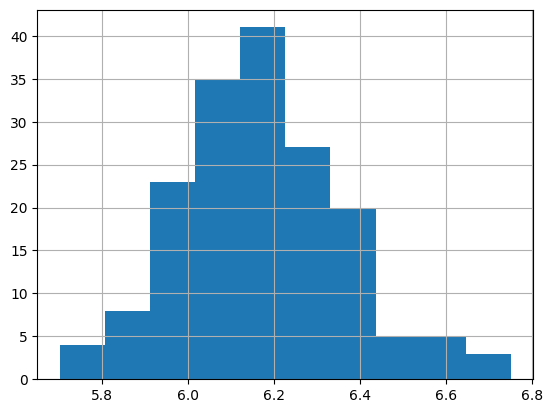

In [490]:
intensity_features_df['pn2_entropy'].hist()

In [495]:
relevant_cols

['pn2_skew_med']

In [492]:
time_features = [
    'Age',
    'tPNf',
    't2',
    't3',
    't4',
    't5',
    't6',
    't7',
    't8',
]

In [493]:
metrics_plus_clinical = pd.merge(df_metrics,merged_df, on='embryo_id')

(array([1., 0., 0., 0., 1., 1., 0., 0., 1., 2., 1., 0., 2., 1., 1., 1., 3.,
        2., 4., 6., 1., 1., 2., 0., 0., 2., 1., 0., 1., 4.]),
 array([0.02120092, 0.02330333, 0.02540574, 0.02750815, 0.02961056,
        0.03171296, 0.03381537, 0.03591778, 0.03802019, 0.0401226 ,
        0.04222501, 0.04432741, 0.04642982, 0.04853223, 0.05063464,
        0.05273705, 0.05483945, 0.05694186, 0.05904427, 0.06114668,
        0.06324909, 0.06535149, 0.0674539 , 0.06955631, 0.07165872,
        0.07376113, 0.07586354, 0.07796594, 0.08006835, 0.08217076,
        0.08427317]),
 <BarContainer object of 30 artists>)

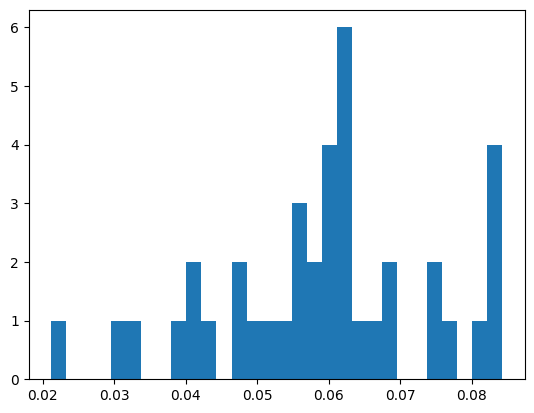

In [494]:
plt.hist(metrics_plus_clinical['mean_area1'], bins=30)

In [480]:
X = metrics_plus_clinical[relevant_cols[:3]].fillna(metrics_plus_clinical[relevant_cols[:3]].mean())

X = metrics_plus_clinical[relevant_cols+time_features].fillna(metrics_plus_clinical[relevant_cols[:-1]+time_features].mean())

y = metrics_plus_clinical['target']

KeyError: "['pn2_skew_med'] not in index"

In [481]:
y.value_counts()/y.shape

target
0.0    0.631579
2.0    0.286550
1.0    0.081871
Name: count, dtype: float64

In [482]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)

In [483]:
X.mean()

eccentricity1    21.398484
max_area1         0.060385
max_area2         0.054678
min_area          0.054676
Age              36.864107
tPNf             23.439661
t2               25.938964
t3               36.768986
t4               38.047424
t5               48.919018
t6               50.821269
t7               53.887011
t8               56.859428
dtype: float64

In [484]:
# one-liner: decorrelate while keeping all variance
from sklearn.decomposition import PCA
X_std   = (X - X.mean()) / X.std()
X_ortho = PCA().fit_transform(X_std.fillna(0))      # same shape, uncorrelat

# X_ortho = TSNE(n_components=2, learning_rate='auto',
#                   init='random', perplexity=3).fit_transform(X_std)


In [485]:
from sklearn.cluster import KMeans, HDBSCAN
kmeans = KMeans(n_clusters=2, random_state=403, n_init="auto").fit(X_ortho)
# kmeans.fit(X_std)
clusters = kmeans.labels_

In [450]:
clusters

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int32)

In [451]:
(metrics_plus_clinical.loc[clusters==1]['target']==2).sum()/metrics_plus_clinical.loc[clusters==1]['target'].shape[0]

np.float64(0.3157894736842105)

In [452]:
(metrics_plus_clinical.loc[clusters==0]['target']==2).sum()/metrics_plus_clinical.loc[clusters==0]['target'].shape[0]

np.float64(0.2719298245614035)

In [453]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# contingency table
tbl = pd.crosstab(kmeans.labels_, df_metrics['target'])
#        target
#label       0    1
#   0      n00  n01
#   1      n10  n11

chi2, p, dof, exp = chi2_contingency(tbl.values, correction=False)
cramers_v = np.sqrt(chi2 / tbl.values.sum())

print(f'χ² = {chi2:.2f} (dof={dof}),  p = {p:.4g}')
print(f"Cramer's V = {cramers_v:.3f}")


χ² = 2.67 (dof=2),  p = 0.2629
Cramer's V = 0.125


/tmp/ipykernel_3841974/2838930224.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap    = plt.cm.get_cmap("Set1", len(classes))


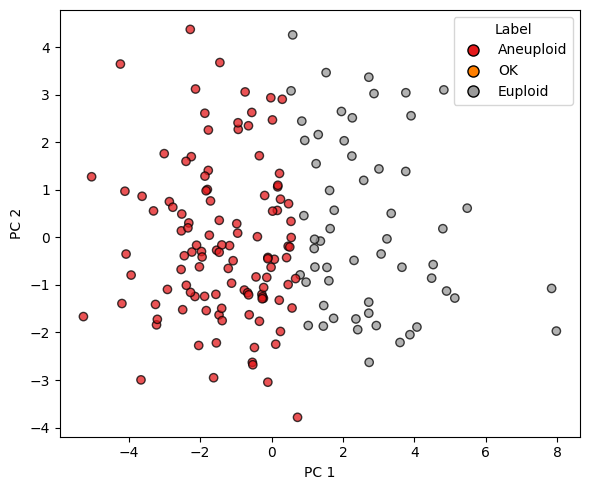

In [454]:
import numpy as np
import matplotlib.pyplot as plt

# y contains 0, 1, 2  ↦  (0 = Aneuploid, 1 = OK, 2 = Euploid)
label_names = {0: "Aneuploid", 1: "OK", 2: "Euploid"}

classes = np.unique(y)                     # [0,1,2]
cmap    = plt.cm.get_cmap("Set1", len(classes))

fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(
    X_ortho[:, 0],
    X_ortho[:, 1],
    c=clusters,
    cmap=cmap,
    alpha=0.75,
    edgecolor="k"
)

# one dummy handle per class so legend colours match the plot
handles = [
    plt.Line2D(
        [], [], marker="o", linestyle="",
        markersize=8,
        markerfacecolor=cmap(i),
        markeredgecolor="k",
        label=label_names[cls]
    )
    for i, cls in enumerate(classes)
]

ax.legend(handles=handles, title="Label")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
plt.tight_layout()
plt.show()


In [353]:
with pm.Model() as m:
    τ   = pm.HalfNormal("τ", 0.5)        # shared shrinkage (horseshoe works too)
    β_z = pm.Normal("β_z", 0, 1,  shape=X_ortho.shape[1])
    β   = pm.Deterministic("β", β_z * τ)  # non-centred

    α   = pm.Normal("α", 0, 2)            # much tighter intercept
    logits = α + pm.math.dot(X_ortho, β)
    pm.Bernoulli("obs", logit_p=logits, observed=y)

    idata = pm.sample(2000, tune=2000,
                      target_accept=0.95,  # start modestly higher
                      max_treedepth=15)


NameError: name 'pm' is not defined

In [354]:
az.summary(idata, var_names=["α","β","τ"])
az.plot_trace(idata, var_names=["α","τ"])
az.plot_pair(idata, var_names=["α","τ"], divergences=True)


NameError: name 'az' is not defined

In [355]:
from scipy.stats import mannwhitneyu
for col in df_metrics.columns[:-2]:

    print(f'======== {col}')
    
    print(mannwhitneyu(df_metrics['target'], df_metrics[col], alternative='less'))

    


======== embryo_id


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [356]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import savgol_filter
import statsmodels.api as sm

# parameters for smoothing
SG_WINDOW = 15  # must be odd
SG_POLYORDER = 3
EMA_SPAN   = 12

# storage lists
ids = []
offsets = []
peak_norms = []
slope1 = []
slope2 = []
dists = []
appear_pn1 = []
appear_pn2 = []
dt_appear = []
fade_pn1 = []
fade_pn2 = []
init_size1 = []
init_size2 = []
avg_degree = []
max_size = []
q1_size = []
q2_size = []

for emb_id in merged_df['embryo_id'].drop_duplicates():
    # --- load & trim PN1 ---
    g1 = full_pn1_df[full_pn1_df['embryo_id'] == emb_id].copy()
    g1['area'] = g1['area'].fillna(1)
    g1['time'] = g1['dt'].cumsum()
    start1, length1 = find_signal(g1['area'].values != 1)
    first_pn = g1.iloc[start1:start1+length1].reset_index(drop=True)

    # --- load & trim PN2 ---
    g2 = full_pn2_df[full_pn2_df['embryo_id'] == emb_id].copy()
    g2['area'] = g2['area'].fillna(1)
    g2['time'] = g2['dt'].cumsum()
    start2, length2 = find_signal(g2['area'].values != 1)

    second_pn = g2.iloc[start2:start2+length2].reset_index(drop=True)

    if first_pn.empty: 
        continue

    if second_pn.empty:
        continue
    
    whole_emb_slice = whole_emb_all_df.loc[whole_emb_all_df['embryo_id']==id_].iloc[start1 : start1 + len1]

    # appearance / fade times
    appear_pn1.append(first_pn.at[0, 'time'])
    appear_pn2.append(second_pn.at[0, 'time'])
    dt_appear.append(appear_pn2[-1] - appear_pn1[-1])
    fade_pn1.append(first_pn.at[first_pn.index[-1], 'time'])
    fade_pn2.append(second_pn.at[second_pn.index[-1], 'time'])

    # initial size ratio
    init_size1.append(first_pn['area'].iloc[:5].mean() / second_pn['area'].iloc[:5].mean())

    # --- smoothing ---
    # Savitzky–Golay
    if len(first_pn['area']) >= SG_WINDOW:
        first_pn['area_sg'] = savgol_filter(first_pn['area'], SG_WINDOW, SG_POLYORDER)/whole_emb_slice['area'].mean()
    else:
        first_pn['area_sg'] = first_pn['area']/whole_emb_slice['area'].mean()
    if len(second_pn['area']) >= SG_WINDOW:
        second_pn['area_sg'] = savgol_filter(second_pn['area'], SG_WINDOW, SG_POLYORDER)/whole_emb_slice['area'].mean()
    else:
        second_pn['area_sg'] = second_pn['area']/whole_emb_slice['area'].mean()

    # Exponential moving average
    first_pn['area_ema']  = first_pn['area'].ewm(span=EMA_SPAN, adjust=False).mean()
    second_pn['area_ema'] = second_pn['area'].ewm(span=EMA_SPAN, adjust=False).mean()

    # --- distance between PNs ---
    dist = np.sqrt((g1['x'].values - g2['x'].values)**2 + (g1['y'].values - g2['y'].values)**2)
    dists.append(np.nanmean(dist))

    # --- offset diff ---
    od = (start2 + length2) - (start1 + length1)
    if od != 0:
        ids.append(emb_id)
        offsets.append(od)

    # --- cross-correlation on SG-smoothed series ---
    sig1 = first_pn['area_sg'].values
    sig2 = second_pn['area_sg'].values
    corr = signal.correlate(sig1, sig2, mode='full')
    peak = np.max(corr)
    norm = np.linalg.norm(sig1) * np.linalg.norm(sig2)
    peak_norms.append(peak / norm if norm != 0 else 0)

    # --- growth slopes via OLS on SG-smoothed ---
    X1 = first_pn['time'].values[:25, None]
    mod1 = sm.OLS(first_pn['area_sg'].values[:25], X1)
    res1 = mod1.fit()
    slope1.append(res1.params[0])

    X2 = second_pn['time'].values[:25, None]
    mod2 = sm.OLS(second_pn['area_sg'].values[:25], X2)
    res2 = mod2.fit()
    slope2.append(res2.params[0])

    # --- size stats ---
    max_size.append(first_pn['area_sg'].max())
    q1_size.append(first_pn['area_sg'].quantile(0.1))
    q2_size.append(first_pn['area_sg'].quantile(0.9))

    # --- orientation ---
    dx = first_pn['x'].values - second_pn['x'].reindex(first_pn.index, method='nearest').values
    dy = first_pn['y'].values - second_pn['y'].reindex(first_pn.index, method='nearest').values
    angles = np.degrees(np.arctan2(dy, dx))
    avg_degree.append(np.nanquantile(angles, 0.1))

    # --- plot raw vs denoised PN1 ---
    lbl = merged_df.loc[merged_df['embryo_id']==emb_id, 'y'].iloc[0]
    color = 'red' if lbl==0 else 'green'
    # plt.plot(first_pn['time'], first_pn['area'],   alpha=0.3, color=color, label='raw' if emb_id==merged_df['embryo_id'].iloc[0] else "")
    plt.plot(second_pn['time'], second_pn['area_sg'], lw=0.31, color=color, label='SG' if emb_id==merged_df['embryo_id'].iloc[0] else "")
    plt.plot(first_pn['time'], first_pn['area_sg'], lw=0.31, color=color, label='SG' if emb_id==merged_df['embryo_id'].iloc[0] else "")
    # plt.plot(first_pn['time'], first_pn['area_ema'], lw=1, ls='--', color=color, label='EMA' if emb_id==merged_df['embryo_id'].iloc[0] else "")
    # break
# finalize plot
plt.xlabel('time')
plt.ylabel('PN1 area')
plt.legend()
plt.show()

KeyError: 'x'

In [357]:
whole_emb_slice['area'].max()

np.float64(32722.0)

In [358]:
second_pn['area_sg'].values[:10]

array([0.03322254, 0.03085167, 0.02992034, 0.03019754, 0.03145223,
       0.0334534 , 0.03597002, 0.03877106, 0.04158668, 0.0444637 ])

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

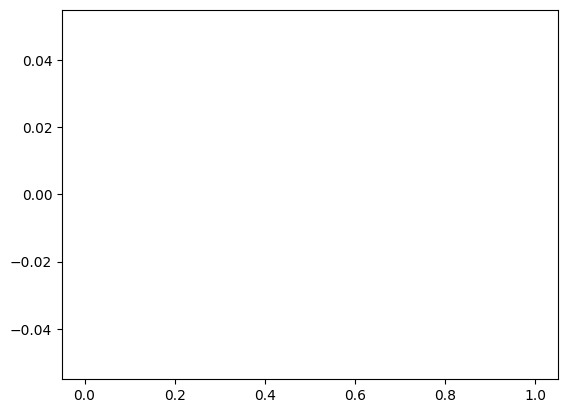

In [359]:
plt.hist(slope1)

In [360]:
X = np.stack([slope1, slope2, dists, dist_to_emb,  init_size1, max_size, q1_size, q2_size]).transpose()


ValueError: all input arrays must have the same shape

In [361]:
pd.merge(df_stats, merged_df[['embryo_id','y']], on='embryo_id').drop('embryo_id',axis=1).corr()

NameError: name 'df_stats' is not defined

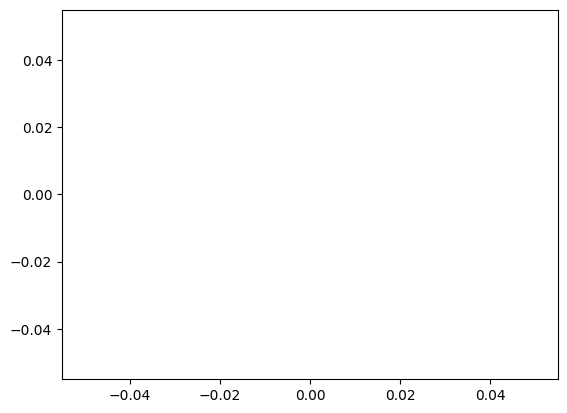

In [362]:
plt.plot(np.array(appear_pn1)-np.array(appear_pn2))

In [363]:

from scipy.stats import pointbiserialr
print(pointbiserialr(target_list, slope1))
print(pointbiserialr(target_list, slope2))
print(pointbiserialr(target_list, dists))
print(pointbiserialr(target_list, dist_to_emb))
print(pointbiserialr(target_list, init_size1))
print(pointbiserialr(target_list, max_size))
print(pointbiserialr(target_list, q1_size))
print(pointbiserialr(target_list, q2_size))
pointbiserialr(target_list,appear_pn1 )
pointbiserialr(target_list,appear_pn2 )

ValueError: `x` and `y` must have length at least 2.

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([36.5, 36.6, 36.7, 36.8, 36.9, 37. , 37.1, 37.2, 37.3, 37.4, 37.5]),
 <BarContainer object of 10 artists>)

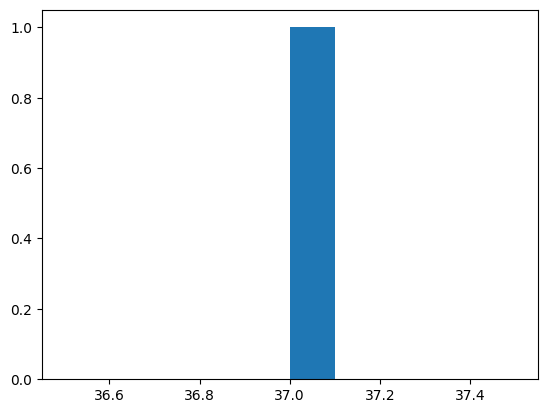

In [364]:
plt.hist(appear_pn2)


In [365]:

from scipy.stats import mannwhitneyu
print(mannwhitneyu(target_list, slope1))
print(mannwhitneyu(target_list, slope2))
print(mannwhitneyu(target_list, dists))
print(mannwhitneyu(target_list, dist_to_emb))
print(mannwhitneyu(target_list, init_size1))
print(mannwhitneyu(target_list, max_size))
print(mannwhitneyu(target_list, q1_size))
print(mannwhitneyu(target_list, q2_size))
mannwhitneyu(target_list,appear_pn1 )
mannwhitneyu(target_list,appear_pn2 )

MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))
MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))
MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))
MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))
MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))
MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))
MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))
MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))


/tmp/ipykernel_3841974/2584278172.py:2: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  print(mannwhitneyu(target_list, slope1))
/tmp/ipykernel_3841974/2584278172.py:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  print(mannwhitneyu(target_list, slope2))
/tmp/ipykernel_3841974/2584278172.py:4: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  print(mannwhitneyu(target_list, dists))
/tmp/ipykernel_3841974/2584278172.py:5: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  print(mannwhitneyu(target_list, dist_to_emb))
/tmp/ipykernel_3841974/2584278172.py:6: SmallSampleWarning: One or more sample arguments

MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))

In [366]:
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, pointbiserialr

def test_feature(feature, target, name="feature", alpha=0.05):
    """
    Run Welch’s t-test, Mann–Whitney U, and point-biserial correlation
    between a continuous `feature` list and binary `target` list.
    """
    x = np.array(feature)
    y = np.array(target)
    # split
    x0 = x[y == 0]
    x1 = x[y == 1]
    # drop NaNs
    x0 = x0[~np.isnan(x0)]
    x1 = x1[~np.isnan(x1)]
    # Welch's t-test
    t_stat, t_p = ttest_ind(x0, x1, equal_var=False, nan_policy='omit')
    # Mann–Whitney U
    u_stat, u_p = mannwhitneyu(x0, x1, alternative='two-sided')
    # point-biserial
    r_pb, r_p = pointbiserialr(y, x)

    if t_p<alpha:
        return True, t_stat
    else: 
        return False, 0

    # print(f"=== {name} ===")
    # print(f"Welch’s t-test:      t = {t_stat:.3f}, p = {t_p:.3e}, significant = {t_p < alpha}")
    # print(f"Mann–Whitney U:      U = {u_stat:.3f}, p = {u_p:.3e}, significant = {u_p < alpha}")
    # print(f"Point-biserial r:    r = {r_pb:.3f}, p = {r_p:.3e}, significant = {r_p < alpha}")
    # print()

# Example usage:/

# test_feature(slope1, target_list, name="slope1")
# test_feature(dists,  target_list, name="dists")


In [367]:
features_all.dropna(axis=1)

NameError: name 'features_all' is not defined

In [368]:
import numpy as np
import pandas as pd
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

def load_trace(df, id_col, id_, area_col='area', dt_col='dt'):
    g = df[df[id_col] == id_].copy().reset_index(drop=True)
    g[area_col] = g[area_col].fillna(1)
    g['time'] = g[dt_col].cumsum()
    start, length = find_signal(g[area_col].values != 1)
    return g.iloc[start:start+length].reset_index(drop=True)

def build_long(df, prefix):
    rows = []
    for emb in merged_df['embryo_id'].unique():
        tr = load_trace(df, 'embryo_id', emb)
        for _, r in tr.iterrows():
            rows.append({'id': emb, 'time': r['time'], f'{prefix}_area': r['area']})
    return pd.DataFrame(rows)

# build tsfresh input tables
pn1_long = build_long(full_pn1_df, 'pn1')
pn2_long = build_long(full_pn2_df, 'pn2')

# extract all available features
fc_params = ComprehensiveFCParameters()
X1 = extract_features(pn1_long, column_id='id', column_sort='time', default_fc_parameters=fc_params)
X2 = extract_features(pn2_long, column_id='id', column_sort='time', default_fc_parameters=fc_params)

# prefix and combine
X1 = X1.add_prefix('pn1__')
X2 = X2.add_prefix('pn2__')
features_all = X1.join(X2)

# attach labels
labels = merged_df.drop_duplicates('embryo_id').set_index('embryo_id')['y']
features_all['label'] = labels

# inspect
print(features_all.shape)
print(features_all.head())


Feature Extraction: 100%|██████████| 72/72 [00:00<00:00, 180.97it/s]


(214, 1567)
                           pn1__pn1_area__variance_larger_than_standard_deviation  \
D2017.01.17_S1470_I149_2                                                 1.0        
D2017.01.17_S1470_I149_5                                                 1.0        
D2017.01.17_S1470_I149_7                                                 1.0        
D2017.01.17_S1470_I149_8                                                 1.0        
D2017.01.17_S1472_I149_10                                                1.0        

                           pn1__pn1_area__has_duplicate_max  \
D2017.01.17_S1470_I149_2                                0.0   
D2017.01.17_S1470_I149_5                                0.0   
D2017.01.17_S1470_I149_7                                0.0   
D2017.01.17_S1470_I149_8                                0.0   
D2017.01.17_S1472_I149_10                               0.0   

                           pn1__pn1_area__has_duplicate_min  \
D2017.01.17_S1470_I149_2           

In [369]:
final_merged = pd.merge(features_all,merged_df[['embryo_id', 'Class_Grade']], left_index=True, right_on='embryo_id')

In [370]:
relevant_features = pd.merge(features_all, merged_df[['embryo_id','y']], left_index=True, right_on='embryo_id').drop('embryo_id',axis=1,).corr()['y'].drop(['y','label']).dropna().abs().sort_values().tail(150).index[1:-1]

In [371]:
relevant_features


Index(['pn1__pn1_area__fft_coefficient__attr_"abs"__coeff_33',
       'pn2__pn2_area__agg_autocorrelation__f_agg_"median"__maxlag_40',
       'pn1__pn1_area__fft_coefficient__attr_"imag"__coeff_32',
       'pn1__pn1_area__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"max"',
       'pn1__pn1_area__index_mass_quantile__q_0.9',
       'pn2__pn2_area__lempel_ziv_complexity__bins_10',
       'pn2__pn2_area__lempel_ziv_complexity__bins_5',
       'pn1__pn1_area__fft_coefficient__attr_"angle"__coeff_30',
       'pn2__pn2_area__fft_coefficient__attr_"imag"__coeff_20',
       'pn2__pn2_area__large_standard_deviation__r_0.25',
       ...
       'pn1__pn1_area__fft_coefficient__attr_"imag"__coeff_42',
       'pn1__pn1_area__fft_coefficient__attr_"imag"__coeff_41',
       'pn2__pn2_area__fft_coefficient__attr_"real"__coeff_42',
       'pn2__pn2_area__fft_coefficient__attr_"imag"__coeff_43',
       'pn1__pn1_area__fft_coefficient__attr_"imag"__coeff_43',
       'pn2__pn2_area__fft_coefficie

In [372]:
# relevant_features = pd.merge(features_all, merged_df[['embryo_id','y']], left_index=True, right_on='embryo_id').drop('embryo_id',axis=1,).corr()['y'].dropna().abs().sort_values().tail(30).index[1:-1]

In [373]:
X = final_merged[relevant_features].fillna(0).values

In [374]:
from sklearn.linear_model import LinearRegression


r2 = LinearRegression().fit(X, y).score(X, y)
print(f"Combined R²: {r2:.3f}")

ValueError: Found input variables with inconsistent numbers of samples: [214, 209]

In [375]:
from scipy.stats import pointbiserialr
pointbiserialr(merged_df['y'],dt_appear )

ValueError: `x` and `y` must have the same length along `axis`.

In [376]:
from scipy.stats import pointbiserialr
pointbiserialr(merged_df['y'], slope2 )

ValueError: `x` and `y` must have the same length along `axis`.

In [377]:
from scipy.stats import pointbiserialr, norm
import numpy as np

# 1. compute r and p
r, p = pointbiserialr(merged_df['y'], slope1)
n = len(merged_df)

# 2. Fisher z-transform and standard error
z = np.arctanh(r)
se = 1/np.sqrt(n - 3)

# 3. critical z for 95% CI
z_crit = norm.ppf(1 - 0.05/2)

# 4. CI in z-space, then back-transform to r
lo_z, hi_z = z - z_crit*se, z + z_crit*se
lo_r, hi_r = np.tanh([lo_z, hi_z])

print(f"r = {r:.3f}, p = {p:.3g}")
print(f"95% CI for r = ({lo_r:.3f}, {hi_r:.3f})")


ValueError: `x` and `y` must have the same length along `axis`.

In [378]:
[len(i) for i in [slope1, slope2, dists, dist_to_emb,  init_size1, max_size, q1_size, q2_size]]

[0, 0, 0, 0, 1, 0, 0, 0]

In [379]:
X = np.stack([slope1, slope2, dists, dist_to_emb,  init_size1, max_size, q1_size, q2_size]).transpose()


ValueError: all input arrays must have the same shape

In [380]:
merged_df.loc[merged_df['embryo_id'].isin(ids)]['y'].sum()

np.float64(0.0)

In [381]:
means = full_pn1_df.groupby('embryo_id').apply(lambda x: x[simple_features].mean())

means1 = full_pn2_df.groupby('embryo_id').apply(lambda x: x[simple_features].mean())

q1 = full_pn2_df.groupby('embryo_id').apply(lambda x: x[simple_features].quantile(0.1))

q2 = full_pn2_df.groupby('embryo_id').apply(lambda x: x[simple_features].quantile(0.9))



/tmp/ipykernel_3841974/2096497004.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  means = full_pn1_df.groupby('embryo_id').apply(lambda x: x[simple_features].mean())
/tmp/ipykernel_3841974/2096497004.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  means1 = full_pn2_df.groupby('embryo_id').apply(lambda x: x[simple_features].mean())
/tmp/ipykernel_3841974/2096497004.py:5: DeprecationWarning: DataFrame

In [382]:
simple_features =['area', 'perimeter', 'eccentricity', 'solidity', 'aspect_ratio', 'x','y']

In [383]:
full_pn1_df.dropna(axis=0, thresh=5)

,index,centroid_row,centroid_col,area,filled_area,perimeter,bbox,bounding_box_area,extent,aspect_ratio,...,eccentricity,euler_number,circularity,feret_diameter_max,hu_moments,skeleton_length,endpoints,dt,embryo_id,time
33,33,147.040248,248.343653,323.0,323.0,74.142136,"(137, 239, 159, 259)",440.0,0.734091,0.909091,...,0.606838,1.0,0.738384,23.021729,"[0.16771301622127918, 0.001432574242342432, 0....",31.0,5.0,1.0,D2017.06.02_S1566_I149_2,34.0
34,34,147.079545,252.431818,176.0,176.0,53.899495,"(139, 246, 157, 259)",234.0,0.752137,0.722222,...,0.766730,1.0,0.761295,18.788294,"[0.17872120938204356, 0.005535758042210605, 0....",21.0,4.0,1.0,D2017.06.02_S1566_I149_2,35.0
36,36,154.161431,250.532286,1146.0,1146.0,142.870058,"(134, 233, 175, 271)",1558.0,0.735558,0.926829,...,0.401352,1.0,0.705524,41.231056,"[0.1608222550118755, 0.00019845758565932293, 1...",72.0,8.0,1.0,D2017.06.02_S1566_I149_2,37.0
37,37,156.194956,249.977505,1467.0,1467.0,156.284271,"(134, 230, 179, 271)",1845.0,0.795122,0.911111,...,0.328832,1.0,0.754761,45.310043,"[0.15997595840173506, 8.360301075960026e-05, 1...",65.0,7.0,1.0,D2017.06.02_S1566_I149_2,38.0
38,38,160.264438,252.182371,987.0,987.0,127.798990,"(143, 235, 177, 271)",1224.0,0.806373,1.058824,...,0.260081,1.0,0.759403,37.121422,"[0.1604353608205532, 3.153986470999492e-05, 4....",51.0,5.0,1.0,D2017.06.02_S1566_I149_2,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28288,78,166.617560,300.933036,2016.0,2016.0,184.769553,"(141, 275, 192, 326)",2601.0,0.775087,1.000000,...,0.191580,1.0,0.742061,52.392748,"[0.15972519895751794, 8.916186898288498e-06, 1...",94.0,10.0,1.0,D2018.03.26_S01756_I0149_D_7,79.0
28289,79,167.604320,299.009651,2176.0,2176.0,197.012193,"(141, 271, 195, 326)",2970.0,0.732660,1.018519,...,0.341880,1.0,0.704503,55.154329,"[0.16019999187492, 9.887012208276608e-05, 1.36...",101.0,8.0,1.0,D2018.03.26_S01756_I0149_D_7,80.0
28290,80,163.803385,298.296167,2009.0,2009.0,184.183766,"(139, 273, 190, 324)",2601.0,0.772395,1.000000,...,0.176966,1.0,0.744196,52.153619,"[0.15954638112351532, 6.441378264027517e-06, 1...",91.0,8.0,1.0,D2018.03.26_S01756_I0149_D_7,81.0
28291,81,164.735165,293.460440,1820.0,1820.0,172.526912,"(141, 271, 190, 317)",2254.0,0.807453,0.938776,...,0.292989,1.0,0.768365,49.819675,"[0.1596288193149683, 5.124723493075302e-05, 1....",74.0,7.0,1.0,D2018.03.26_S01756_I0149_D_7,82.0


In [384]:
full_pn1_df.fillna(0)

,index,centroid_row,centroid_col,area,filled_area,perimeter,bbox,bounding_box_area,extent,aspect_ratio,...,eccentricity,euler_number,circularity,feret_diameter_max,hu_moments,skeleton_length,endpoints,dt,embryo_id,time
0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,D2017.06.02_S1566_I149_2,1.0
1,1,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,D2017.06.02_S1566_I149_2,2.0
2,2,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,D2017.06.02_S1566_I149_2,3.0
3,3,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,D2017.06.02_S1566_I149_2,4.0
4,4,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,D2017.06.02_S1566_I149_2,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28335,125,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,D2018.03.26_S01756_I0149_D_7,126.0
28336,126,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,D2018.03.26_S01756_I0149_D_7,127.0
28337,127,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,D2018.03.26_S01756_I0149_D_7,128.0
28338,128,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,D2018.03.26_S01756_I0149_D_7,129.0


In [385]:
extract_features(full_pn1_df[simple_features+['embryo_id', 'time']].fillna(0), column_id='embryo_id', column_sort='time', default_fc_parameters=settings)



KeyError: "['x', 'y'] not in index"

In [386]:
intensity_features = ['mean_intensity', 'median_intensity', 'std_intensity',
       'min_intensity', 'max_intensity', 'skewness', 'kurtosis', 'entropy',
       'percentile_10', 'percentile_25', 'percentile_75', 'percentile_90',
       'glcm_contrast', 'glcm_dissimilarity', 'glcm_homogeneity', 'glcm_ASM',
       'glcm_energy', 'glcm_correlation', 'embryo_id', 'time']

In [390]:
simple_features

['area', 'perimeter', 'eccentricity', 'solidity', 'aspect_ratio', 'x', 'y']

In [388]:
full_pn1_intens_df.groupby('embryo_id').apply(lambda x: x.iloc[0]).loc[full_pn1_intens_df.groupby('embryo_id').apply(lambda x: x.dropna(thresh=2).time.max()*AVERAGE_TIMESTEP<20)]['embryo_id'].index

/tmp/ipykernel_3841974/620724128.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  full_pn1_intens_df.groupby('embryo_id').apply(lambda x: x.iloc[0]).loc[full_pn1_intens_df.groupby('embryo_id').apply(lambda x: x.dropna(thresh=2).time.max()*AVERAGE_TIMESTEP<20)]['embryo_id'].index
/tmp/ipykernel_3841974/620724128.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  full_pn1_intens_df.groupby('embryo_id').ap

Index(['D2017.01.17_S1470_I149_2', 'D2017.01.17_S1470_I149_5',
       'D2017.01.17_S1470_I149_7', 'D2017.01.17_S1470_I149_8',
       'D2017.01.24_S1480_I149_1', 'D2017.01.24_S1480_I149_10',
       'D2017.01.24_S1480_I149_11', 'D2017.01.24_S1480_I149_2',
       'D2017.01.24_S1480_I149_5', 'D2017.01.24_S1480_I149_6',
       'D2017.01.24_S1480_I149_7', 'D2017.01.24_S1480_I149_9',
       'D2017.02.07_S1493_I149_12', 'D2017.02.07_S1493_I149_3',
       'D2017.02.07_S1493_I149_4', 'D2017.02.07_S1493_I149_9',
       'D2017.07.18_S1600_I149_3', 'D2017.07.18_S1600_I149_4',
       'D2017.07.18_S1600_I149_6', 'D2017.07.18_S1601_I149_6',
       'D2017.07.18_S1601_I149_7', 'D2017.11.24_S01669_I0149_D_2',
       'D2017.11.24_S01669_I0149_D_3', 'D2017.11.24_S01669_I0149_D_4',
       'D2018.02.13_S01720_I0149_D_5', 'D2018.10.11_S01880_I0149_D_9',
       'D2018.11.20_S01902_I0149_D_1', 'D2018.11.20_S01902_I0149_D_2',
       'D2018.11.20_S01902_I0149_D_3', 'D2018.11.20_S01902_I0149_D_7',
       'D2018.11

In [391]:
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
# ...
from tsfresh.feature_extraction import extract_features
settings = ComprehensiveFCParameters()
# Set here the options of the settings object as shown in the paragraphs below
features_to_remove = [
    # raw-length or count-based features
    "length",
    "count_above_mean",
    "count_below_mean",
    "number_crossing_m",
    "number_cwt_peaks",
    "number_peaks",
    "query_similarity_count",
    "range_count",
    "value_count",
    "sum_values",
    "sum_of_reoccurring_data_points",
    "absolute_sum_of_changes",
    # absolute-position features
    "first_location_of_maximum",
    "first_location_of_minimum",
    # longest-strike lengths
    "longest_strike_above_mean",
    "longest_strike_below_mean",
]


for f in features_to_remove:
    settings.pop(f, None)

extracted_features = extract_features(full_pn1_intens_df[intensity_features].dropna(thresh=3), column_id='embryo_id', column_sort='time', default_fc_parameters=settings)


extracted_features2 = extract_features(full_pn2_intens_df[intensity_features].dropna(thresh=3), column_id='embryo_id', column_sort='time', default_fc_parameters=settings)


extracted_features3 = extract_features(full_pn1_df[simple_features[:2]+['embryo_id', 'time']].dropna(thresh=3), column_id='embryo_id', column_sort='time', default_fc_parameters=settings)


extracted_features4 = extract_features(full_pn1_df[simple_features[:2]+['embryo_id', 'time']].dropna(thresh=3), column_id='embryo_id', column_sort='time', default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 72/72 [00:00<00:00, 94.02it/s] 


In [392]:
extracted_features

,glcm_energy__variance_larger_than_standard_deviation,glcm_energy__has_duplicate_max,glcm_energy__has_duplicate_min,glcm_energy__has_duplicate,glcm_energy__abs_energy,glcm_energy__mean_abs_change,glcm_energy__mean_change,glcm_energy__mean_second_derivative_central,glcm_energy__median,glcm_energy__mean,...,glcm_ASM__fourier_entropy__bins_3,glcm_ASM__fourier_entropy__bins_5,glcm_ASM__fourier_entropy__bins_10,glcm_ASM__fourier_entropy__bins_100,glcm_ASM__permutation_entropy__dimension_3__tau_1,glcm_ASM__permutation_entropy__dimension_4__tau_1,glcm_ASM__permutation_entropy__dimension_5__tau_1,glcm_ASM__permutation_entropy__dimension_6__tau_1,glcm_ASM__permutation_entropy__dimension_7__tau_1,glcm_ASM__mean_n_absolute_max__number_of_maxima_7
D2017.01.17_S1470_I149_2,0.0,0.0,0.0,0.0,1.138112,0.024875,0.008541,0.014849,0.530502,0.533101,...,1.098612,1.098612,1.098612,1.098612,0.693147,-0.000000,NaN,NaN,NaN,NaN
D2017.01.17_S1470_I149_5,0.0,0.0,0.0,0.0,1.366571,0.018282,0.006070,0.002920,0.475696,0.477010,...,1.039721,1.039721,1.386294,1.386294,1.039721,1.098612,0.693147,-0.000000,NaN,NaN
D2017.01.17_S1470_I149_7,0.0,0.0,0.0,0.0,4.634080,0.015996,-0.001111,0.000523,0.536030,0.537815,...,0.683739,1.214890,1.522955,1.889159,1.772139,2.564949,2.484907,2.397895,2.302585,0.308226
D2017.01.17_S1470_I149_8,0.0,0.0,0.0,0.0,3.035880,0.008763,0.000663,0.000261,0.448723,0.449803,...,0.974315,0.974315,1.255482,2.079442,1.671595,2.369382,2.397895,2.302585,2.197225,0.209523
D2017.01.17_S1472_I149_10,0.0,0.0,0.0,0.0,12.390650,0.023801,0.000928,-0.000092,0.452040,0.463867,...,0.575730,1.141138,1.559963,2.871220,1.764269,2.919943,3.662825,3.897925,3.931826,0.308389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D2019.04.16_S01982_I0149_D_5,0.0,0.0,0.0,0.0,16.095425,0.019789,0.001842,-0.001138,0.521728,0.520701,...,0.291140,0.434944,0.434944,1.750908,1.781355,3.067520,3.805690,3.911968,3.970292,0.344780
D2019.04.16_S01982_I0149_D_7,0.0,0.0,0.0,0.0,16.524715,0.023448,-0.000103,-0.000440,0.534985,0.541452,...,0.298758,0.298758,0.446244,1.800221,1.769978,2.900825,3.711308,3.904643,3.912023,0.382472
D2019.04.20_S01983_I0149_D_5,0.0,0.0,0.0,0.0,15.805199,0.024300,-0.001953,0.001425,0.514108,0.516535,...,0.769776,1.171060,1.771254,2.950426,1.717013,2.836615,3.518918,3.850934,3.970292,0.333759
D2019.04.22_S01986_I0149_D_10,0.0,0.0,0.0,0.0,13.156599,0.023824,0.000592,-0.000203,0.465286,0.466257,...,0.473981,0.703962,1.254221,2.768243,1.749321,2.990619,3.749768,3.922204,3.988984,0.304436


In [393]:

both_pn_extracted1 = pd.merge(extracted_features, extracted_features2, left_index=True, right_index=True)


both_pn_extracted2 = pd.merge(extracted_features3, extracted_features4, left_index=True, right_index=True)


both_pn_extracted = pd.merge(both_pn_extracted1, both_pn_extracted2, left_index=True, right_index=True)

non_dead_features = list(both_pn_extracted.var().loc[(both_pn_extracted.var()<100000)&(both_pn_extracted.var()>1)].index)

/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [394]:


both_pn_extracted = both_pn_extracted[non_dead_features].reset_index(names='embryo_id')

In [395]:
both_pn_extracted = both_pn_extracted.loc[~both_pn_extracted['embryo_id'].isin(full_pn1_intens_df.groupby('embryo_id').apply(lambda x: x.iloc[0]).loc[full_pn1_intens_df.groupby('embryo_id').apply(lambda x: x.dropna(thresh=2).time.max()*AVERAGE_TIMESTEP<20)]['embryo_id'].index)]

/tmp/ipykernel_3841974/45772217.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  both_pn_extracted = both_pn_extracted.loc[~both_pn_extracted['embryo_id'].isin(full_pn1_intens_df.groupby('embryo_id').apply(lambda x: x.iloc[0]).loc[full_pn1_intens_df.groupby('embryo_id').apply(lambda x: x.dropna(thresh=2).time.max()*AVERAGE_TIMESTEP<20)]['embryo_id'].index)]
/tmp/ipykernel_3841974/45772217.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns afte

In [396]:
from sklearn.model_selection import train_test_split

In [397]:
with_targ = pd.merge(merged_df[['y','embryo_id']], both_pn_extracted[non_dead_features+['embryo_id']], on='embryo_id', how='right')

In [398]:
train_ids, test_ids = train_test_split(with_targ['embryo_id'], random_state=42, stratify=with_targ['y']>1)

In [399]:
train_data = with_targ.loc[with_targ['embryo_id'].isin(train_ids)].fillna(0)

y_train = train_data['y'].fillna(0)>1

X_train = train_data.drop(['embryo_id', 'y'], axis=1).fillna(0)


test_data = with_targ.loc[with_targ['embryo_id'].isin(test_ids)].fillna(0)

y_test = test_data['y'].fillna(0)>1

X_test = test_data.drop(['embryo_id', 'y'], axis=1)

In [404]:
from sklearn.decomposition import PCA
# 1. Re‐build your pipeline so that you fill missing values *before* standardizing,
#    and use exactly the same means and stds for both train and test.
pca = PCA(n_components=10)
# Fill NaNs in the TRAIN set with the TRAIN means
X_train_filled = X_train.fillna(X_train.mean())

# Compute train‐set mean and std (and guard against zero‐variance columns)
train_mean = X_train_filled.mean()
train_std = X_train_filled.std().replace(0, 1)  # avoid division by zero

# Standardize TRAIN set
X_std_train = (X_train_filled - train_mean) / train_std

# Fit PCA on the properly standardized TRAIN set
X_train_pca = pca.fit_transform(X_std_train)


# 2. Now apply the *same* fill/scale to TEST

# Re‐order TEST columns to match TRAIN exactly (if needed)
X_test = X_test[X_train.columns]

# Fill NaNs in TEST with the TRAIN means
X_test_filled = X_test.fillna(train_mean)

# Standardize TEST using TRAIN‐set mean/std
X_std_test = (X_test_filled - train_mean) / train_std

# Project TEST onto PCA axes (no .fit here, only .transform)
X_test_pca = pca.transform(X_std_test)


In [405]:
from sklearn.linear_model import LogisticRegression



clf =RandomForestClassifier()
clf.fit(X_train_pca, y_train)

RandomForestClassifier()

In [406]:
roc_auc_score(y_test,clf.predict_proba(X_test_pca)[:,1])

np.float64(0.42075892857142855)

In [403]:
kmeans =KMeans(n_clusters=2, random_state=40)

kmeans.fit(X_train_pca[:,:2])

KMeans(n_clusters=2, random_state=40)

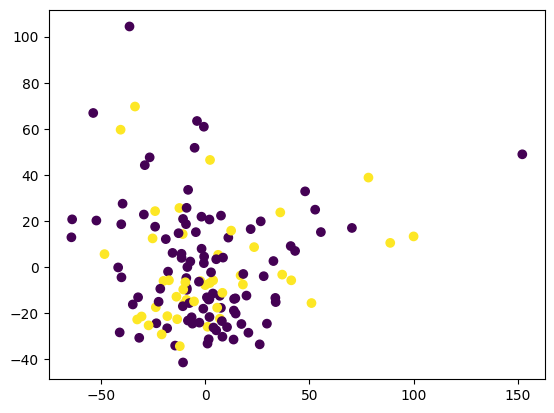

In [185]:
plt.scatter(X_train_pca[:,0],X_train_pca[:,1], c=y_train)

In [186]:
train_data

,y,embryo_id,percentile_90__mean_abs_change_x,percentile_90__median_x,percentile_90__mean_x,percentile_90__standard_deviation_x,percentile_90__variance_x,percentile_90__skewness_x,percentile_90__kurtosis_x,percentile_90__root_mean_square_x,...,"area__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""var""_y","area__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""min""_y","area__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""_y","area__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""_y","area__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""_y","area__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""_y","area__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""min""_y","area__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""_y","area__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""_y","area__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""_y"
1,0.0,D2017.01.17_S1472_I149_2,1.465789,100.0,99.893506,2.704846,7.316192,0.406484,0.137129,99.930120,...,-1.0,457.0,27.553495,41.940310,34.394334,29.009656,131.078342,103.392376,-2.931852,0.0
2,2.0,D2017.01.17_S1472_I149_3,1.768966,99.0,99.738983,3.169827,10.047802,0.990766,5.456061,99.789341,...,1.0,99.0,25.951980,101.935701,65.519517,57.547413,390.368968,170.851782,-2.926448,0.0
6,2.0,D2017.01.24_S1480_I149_6,10.663636,108.0,107.117391,10.347554,107.071871,-1.854307,4.325814,107.616018,...,0.0,0.0,297.188935,153.983895,183.081641,127.305734,482.953500,366.771381,-3.156053,9.0
7,2.0,D2017.01.24_S1480_I149_7,3.005405,114.0,114.731579,5.515963,30.425845,0.857870,0.820286,114.864098,...,0.0,0.0,121.057256,146.832390,90.385693,413.196539,175.848457,228.741320,-2.201779,1.0
8,2.0,D2017.01.24_S1480_I149_8,2.520000,110.0,110.902778,3.872014,14.992492,1.141144,1.207155,110.970350,...,0.0,0.0,87.336137,160.951195,105.960433,337.639749,500.185246,143.836200,-1.393317,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,1.0,D2019.04.12_S01977_I0149_D_10,2.372414,107.2,107.988136,3.996952,15.975622,-0.568397,2.370936,108.062080,...,1.0,83.0,16.523459,73.700203,33.139376,18.598442,286.344131,94.653557,-2.192718,0.0
185,0.0,D2019.04.16_S01982_I0149_D_5,2.412308,102.0,97.578788,11.064501,122.423186,-0.575265,-0.736225,98.204089,...,1.0,20.0,56.196962,63.966084,55.164710,38.316219,195.160692,91.637023,-2.397164,1.0
186,0.0,D2019.04.16_S01982_I0149_D_7,1.533333,110.0,110.484375,3.653518,13.348193,0.617348,-0.362915,110.544766,...,-1.0,448.0,14.020061,24.759157,18.914414,31.859769,75.235438,50.660042,-4.473061,11.0
187,0.0,D2019.04.20_S01983_I0149_D_5,1.891304,99.0,99.587234,5.130701,26.324092,3.543906,15.230565,99.719312,...,0.0,0.0,80.914369,113.317123,95.723096,74.920291,432.870215,180.787092,-2.414570,0.0


In [187]:
df_with_clusters = train_data.copy()
df_with_clusters['y'] = df_with_clusters['y']>1

df_with_clusters['cluster'] = kmeans.labels_

# Compute mean difference for each feature
means = df_with_clusters.iloc[:,2:].groupby('cluster').mean()
mean_diff = (means.iloc[0] - means.iloc[1]).abs().sort_values(ascending=False)
# mean_diff.to_csv('feature_mean_differences.csv')

NameError: name 'kmeans' is not defined

In [188]:
list(mean_diff.index)[:10]

NameError: name 'mean_diff' is not defined

In [189]:
df_with_clusters.loc[df_with_clusters['cluster']==0]['y'].value_counts()/df_with_clusters.loc[df_with_clusters['cluster']==0].shape[0]

KeyError: 'cluster'

In [190]:
df_with_clusters.loc[df_with_clusters['cluster']==1]['y'].value_counts()/df_with_clusters.loc[df_with_clusters['cluster']==1].shape[0]

KeyError: 'cluster'

In [2670]:
# 1. Make sure the test frame has exactly the same columns (in the same order) as X_train:
common_cols = X_train.columns
X_test = X_test[common_cols]

# 2. Fill NaNs in X_test with the training‐set column means:
X_test_filled = X_test.fillna(X_train.mean())

# 3. Compute the training‐set std and guard against any zero‐variance columns:
train_std = X_train.std().replace(0, 1)  # replace zeroes so we don’t divide by zero

# 4. Standardize X_test using the TRAINING mean and std:
X_std_test = (X_test_filled - X_train.mean()) / train_std

# 5. Project onto the same PCA axes (no .fit, only .transform):
X_test_pca = pca.transform(X_std_test)


In [2508]:
X_test_pca[1:,0].shape

(53,)

In [2509]:
X_test_pca[1:,1].shape

(53,)

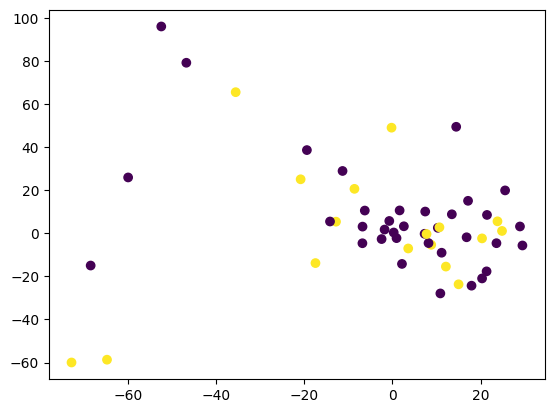

In [2510]:
plt.scatter(X_test_pca[1:,0],X_test_pca[1:,1], c=y_test[1:])

In [2511]:
clf = LGBMClassifier(random_state=42)

In [2512]:
X_selected.columns

Index(['min_intensity__sum_values_y', 'min_intensity__variance_y',
       'percentile_10__sum_values_y', 'glcm_contrast__sum_values_y'],
      dtype='object')

In [2513]:
X_tr_sel

,"area__fft_coefficient__attr_""imag""__coeff_15_x","area__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0_y","area__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2_y","area__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4_y","area__fft_coefficient__attr_""real""__coeff_3_y","area__fft_coefficient__attr_""real""__coeff_49_y","area__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""_y","area__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""_y"
0,0.000000,1607.614858,1607.614858,1607.614858,-142.142209,433.087648,1638.753366,1867.605429
2,-7497.973598,6517.793389,6517.793389,6517.793389,7698.626974,971.108320,20476.239024,84016.671000
3,-339.338429,31055.166587,31055.166587,31055.166587,26675.232915,-511.155825,84518.689561,253431.325714
4,-346.198631,36723.808944,36723.808944,36723.808944,21039.497472,2031.354562,27832.523512,184247.366429
6,-5114.781941,66219.648241,66219.648241,66219.648241,-7632.494267,-1156.674960,81369.704390,114670.601000
...,...,...,...,...,...,...,...,...
206,-1019.035817,50007.437186,50007.437186,50007.437186,23029.576140,233.112728,41824.952195,89571.581571
207,-1310.438111,24078.170854,24078.170854,24078.170854,17294.718572,-1260.339490,30320.788780,61513.736429
208,-859.568895,92442.010050,92442.010050,92442.010050,-2206.705744,379.871024,83368.236585,99292.219571
209,-773.009271,45697.587940,45697.587940,45697.587940,12206.242562,-557.734672,39761.482732,55498.235857


In [2166]:
X_train_pca.σηαπε

AttributeError: 'numpy.ndarray' object has no attribute 'σηαπε'

In [2164]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from copy import deepcopy

# Assuming feature_selection_pipeline and clf are already defined

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

clfs = []
for train_idx, test_idx in kf.split(X_train, y_train):
    X_tr, X_te = X_train_pca[train_idx], X_train_pca[test_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    # # Fit feature selection on the training fold
    # feature_selection_pipeline.fit(X_tr, y_tr)
    # X_tr_sel = feature_selection_pipeline.transform(X_tr)
    # X_te_sel = feature_selection_pipeline.transform(X_te)


    # Fit classifier and score on the test fold
    clf.fit(X_tr, y_tr)

    clfs.append((deepcopy(clf), list(X_te_sel.columns)))
    scores.append(clf.score(X_te, y_te))

print("CV scores:", np.array(scores))
print("Mean CV score:", np.mean(scores))


CV scores: [0.60606061 0.54545455 0.54545455 0.5625     0.46875   ]
Mean CV score: 0.5456439393939394


/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_de

In [483]:
all_probas = []
for clf_, features in clfs:
    all_probas.append(clf_.predict_proba(X_test[features].values)[:,1])

/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/tsakalis/ntua/phd/pronuclei_de

In [484]:
np.sum(all_probas,axis=0)/5

array([0.6420546 , 0.5067157 , 0.27431581, 0.68275486, 0.19620755,
       0.44583722, 0.50378406, 0.33910024, 0.30772142, 0.56225199,
       0.67400868, 0.29246821, 0.4465153 , 0.5502796 , 0.16511549,
       0.31754352, 0.31747112, 0.40629759, 0.38524739, 0.26228709,
       0.59096364, 0.50251025, 0.59112484, 0.2120253 , 0.21397803,
       0.61965136, 0.38657593, 0.42305187, 0.18149327, 0.32900267,
       0.22320786, 0.19840089, 0.63075526, 0.21691729, 0.22335689,
       0.25540986, 0.27293619, 0.1405594 , 0.45730258, 0.25255296,
       0.21362736, 0.13659809, 0.15823473, 0.2134467 , 0.21053744,
       0.22383401, 0.2487565 , 0.28537344, 0.0929428 , 0.66839185,
       0.10947961, 0.20375687, 0.21983232, 0.37017129, 0.32292137])

In [485]:
roc_auc_score(y_test, np.sum(all_probas,axis=0)/5)

np.float64(0.5615615615615616)

In [198]:
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score,confusion_matrix

In [96]:
# X = with_targ.drop(['y','embryo_id'],axis=1)

# X = X.loc[:,as_]
y =pd.Series(target_list)>1#=with_targ['y']

In [83]:
test_feature?

Signature: test_feature(feature, target, name='feature', alpha=0.05)
Docstring:
Run Welch’s t-test, Mann–Whitney U, and point-biserial correlation
between a continuous `feature` list and binary `target` list.
File:      /tmp/ipykernel_2419386/4145221716.py
Type:      function

In [84]:

# ---- 1. Split into train/held-out test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=420
)

In [85]:
as_ = []
for col in X.columns:
    a, b = test_feature(X_trainval[col], y_trainval, col)
    as_.append(a)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [86]:
sum(as_)

0

In [87]:
X.loc[:,as_]

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [88]:
pn1_features['time'] = pn1_features['dt'].cumsum()
pn2_features['time'] = pn2_features['dt'].cumsum()

In [89]:

train_test_split?

Signature:
train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Docstring:
Split arrays or matrices into random train and test subsets.

Quick utility that wraps input validation,
``next(ShuffleSplit().split(X, y))``, and application to input data
into a single call for splitting (and optionally subsampling) data into a
one-liner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. If ``train_size`` is also None, it will
    be set to 0.25.

trai

In [90]:
X

array([[2959.13560745, 3358.97745458,   39.41439999, ..., 1914.94405594,
        1396.50358974, 1868.30675991],
       [2101.50416308, 2246.73481343,   26.96348345, ..., 1574.95804196,
        1055.64708625, 1525.35594406],
       [2334.41335406, 2307.63127939,   31.59882908, ..., 1844.29137529,
        1085.97995338, 1715.73799534],
       ...,
       [2120.84211453, 2267.730732  ,   30.89823848, ..., 1781.3030303 ,
        1195.77622378, 1682.2044289 ],
       [2708.83209848, 2726.68517106,   19.45001996, ..., 1962.68764569,
         825.46853147, 1788.51515152],
       [2634.75703126, 3058.84447149,   24.41742744, ..., 2238.55244755,
        1210.44988345, 1807.03729604]], shape=(215, 8))

In [94]:
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

In [735]:
list(X.columns)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [92]:
pd.DataFrame(X).dropna()

,0,1,2,3,4,5,6,7
0,2959.135607,3358.977455,39.414400,22.764789,0.845966,1914.944056,1396.503590,1868.306760
1,2101.504163,2246.734813,26.963483,19.877374,0.959208,1574.958042,1055.647086,1525.355944
2,2334.413354,2307.631279,31.598829,43.103420,0.946775,1844.291375,1085.979953,1715.737995
3,2690.684613,2848.777694,27.958043,42.018471,1.077742,1751.804196,1424.206993,1710.338555
4,1753.440259,2039.361155,9.764922,18.464918,1.512228,1215.391608,782.218648,1157.174825
...,...,...,...,...,...,...,...,...
210,3328.900768,1074.546956,30.921962,24.736542,2.828470,1925.671329,1241.773986,1914.026573
211,4071.764849,2044.048405,52.605558,50.775295,1.866959,1673.000000,271.500000,1533.000000
212,2120.842115,2267.730732,30.898238,15.107360,0.966012,1781.303030,1195.776224,1682.204429
213,2708.832098,2726.685171,19.450020,22.067730,1.191039,1962.687646,825.468531,1788.515152


In [736]:
import shap

In [738]:
X

,eccentricity1
0,32.002720
1,21.010239
2,43.103420
3,9.691890
4,18.464918
...,...
210,24.736542
211,50.775295
212,26.218057
213,31.898681


In [737]:
from sklearn.utils import shuffle

y_shuffled = shuffle(y, random_state=42)


In [741]:
aucs = []
for i in range(100
):
        
    folds = StratifiedKFold(5, random_state=i, shuffle=True)
    for train_idx, test_idx in folds.split(X,y):


        X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

        # selected = X_train.corrwith(y_train).abs().sort_values().tail(150).index
        # X_train = X_train[selected].values
        # X_test = X_test[selected].values
        # decent_corr_features = list(X_train.corrwith(y_train).abs().sort_values().tail(15000).index)
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        aucs.append(roc_auc_score(y_test,clf.predict(X_test)))
    # print(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]))

In [703]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X)

NameError: name 'shap' is not defined

In [743]:
X.corr()

,eccentricity1,eccentricity2,lifetime1,lifetime2,auc1,auc2,max_area1,mean_area1,area_diff,end_time1,end_time2,overlap_duration,growth_rate1,growth_rate2,mean_midpoint_dist,convergence_rate
eccentricity1,1.000000,-0.051351,-0.012105,-0.011484,0.052716,0.044396,0.116638,0.033951,0.046001,0.032850,0.033943,-0.020841,0.218970,0.135709,0.593459,-0.235185
eccentricity2,-0.051351,1.000000,-0.150164,-0.135385,-0.133332,-0.124021,-0.081833,-0.038175,0.037549,-0.057158,-0.054124,-0.154884,0.080857,0.068479,0.572352,-0.073033
lifetime1,-0.012105,-0.150164,1.000000,0.976285,0.906797,0.901701,-0.081119,-0.242653,-0.362033,0.879276,0.869265,0.979672,-0.474095,-0.408497,0.013447,0.101456
lifetime2,-0.011484,-0.135385,0.976285,1.000000,0.879515,0.920779,-0.099593,-0.240461,-0.416183,0.863592,0.854085,0.990909,-0.489632,-0.425497,0.019150,0.113029
auc1,0.052716,-0.133332,0.906797,0.879515,1.000000,0.942365,0.234765,0.096507,-0.221650,0.788583,0.768703,0.888683,-0.422847,-0.357858,-0.022356,0.093051
auc2,0.044396,-0.124021,0.901701,0.920779,0.942365,1.000000,0.151728,0.012036,-0.397006,0.783269,0.770802,0.919724,-0.437489,-0.385006,-0.011872,0.103325
max_area1,0.116638,-0.081833,-0.081119,-0.099593,0.234765,0.151728,1.000000,0.878948,0.250814,-0.149228,-0.174240,-0.083457,0.078839,0.048790,-0.123935,0.042332
mean_area1,0.033951,-0.038175,-0.242653,-0.240461,0.096507,0.012036,0.878948,1.000000,0.228594,-0.359875,-0.379511,-0.219540,-0.020586,0.049115,-0.218929,0.085920
area_diff,0.046001,0.037549,-0.362033,-0.416183,-0.221650,-0.397006,0.250814,0.228594,1.000000,-0.304304,-0.321888,-0.409062,0.210692,0.281069,0.000394,-0.062352
end_time1,0.032850,-0.057158,0.879276,0.863592,0.788583,0.783269,-0.149228,-0.359875,-0.304304,1.000000,0.983948,0.849327,-0.347688,-0.374176,0.119738,0.057674


(array([  4.,  25.,  65., 119., 125.,  58.,  68.,  25.,   7.,   4.]),
 array([0.37931034, 0.41108374, 0.44285714, 0.47463054, 0.50640394,
        0.53817734, 0.56995074, 0.60172414, 0.63349754, 0.66527094,
        0.69704433]),
 <BarContainer object of 10 artists>)

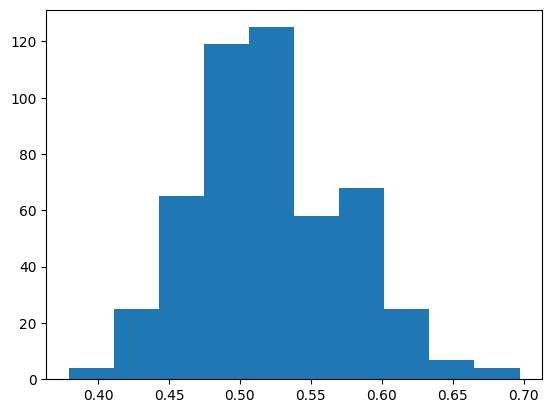

In [742]:
plt.hist(aucs)

(array([  2.,   1.,  10.,  32.,  83., 120., 132.,  80.,  38.,   2.]),
 array([0.24630542, 0.29962359, 0.35294177, 0.40625995, 0.45957812,
        0.5128963 , 0.56621448, 0.61953265, 0.67285083, 0.726169  ,
        0.77948718]),
 <BarContainer object of 10 artists>)

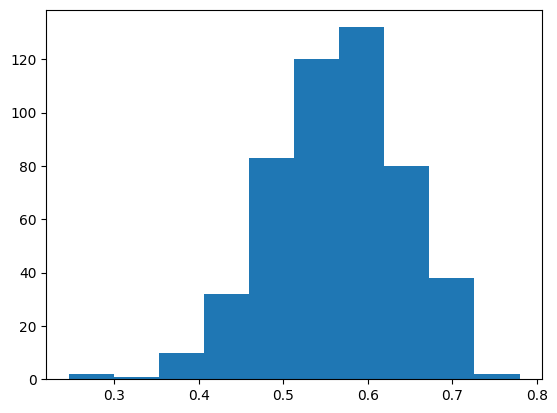

In [719]:
plt.hist(aucs)

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X, y, n_repeats=10, random_state=42)
importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)


<Axes: >

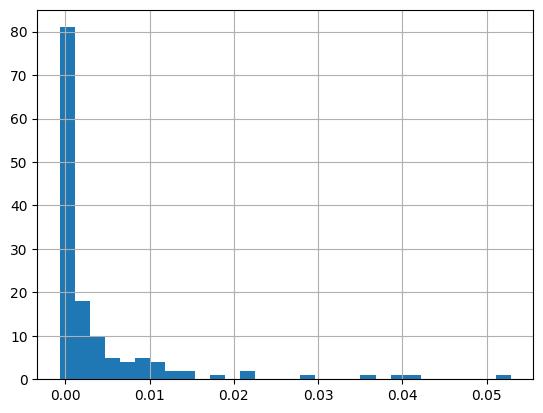

In [635]:
importances.hist(bins=30)

In [630]:
importances.abs().sort_values()

area__fft_coefficient__attr_"abs"__coeff_0_x                              0.000000
area__fft_coefficient__attr_"imag"__coeff_28_x                            0.000000
perimeter__spkt_welch_density__coeff_5_x                                  0.000000
area__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"_x    0.000000
area__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"mean"_x     0.000000
                                                                            ...   
perimeter__fft_coefficient__attr_"abs"__coeff_4_x                         0.028076
perimeter__fft_coefficient__attr_"abs"__coeff_66_x                        0.035692
area__fft_coefficient__attr_"imag"__coeff_61_x                            0.040190
solidity__fft_coefficient__attr_"angle"__coeff_46_x                       0.041276
area__fft_coefficient__attr_"real"__coeff_57_x                            0.052874
Length: 139, dtype: float64

permutation_importance?

Text(0.5, 1.0, 'AUCS')

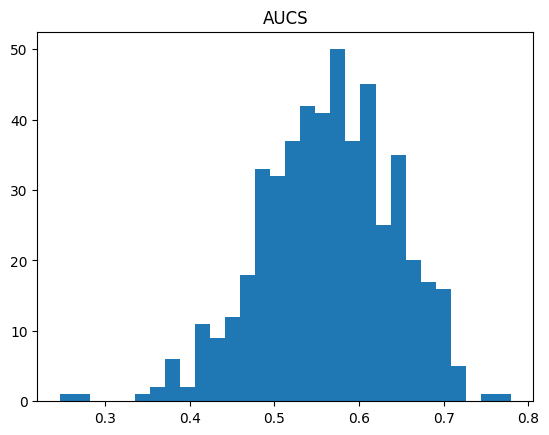

In [706]:
plt.hist(aucs, bins=30)
plt.title('AUCS')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     0.563  0.004     0.557      0.571        0.0      0.0    7689.0   
sigma  0.079  0.002     0.074      0.084        0.0      0.0    7118.0   

       ess_tail  r_hat  
mu       5346.0    1.0  
sigma    5492.0    1.0  
P(mu > 0.5) = 1.000


<Axes: title={'center': 'mu'}>

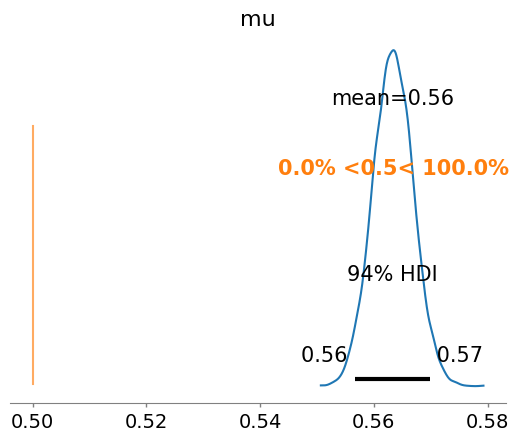

In [710]:
import pymc as pm
import arviz as az
# 2. Build a simple Bayesian model for the AUC distribution
with pm.Model() as auc_model:
    # Prior on the mean AUC (centered at 0.5 with some spread)
    mu = pm.Normal("mu", mu=0.5, sigma=0.1)
    # Prior on the standard deviation of AUCs
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    # Likelihood: observed AUCs ~ Normal(mu, sigma)
    observed = pm.Normal("observed", mu=mu, sigma=sigma, observed=aucs)
    trace = pm.sample(2000, tune=1000, target_accept=0.9, random_seed=42)

# 3. Summarize and compute probability that mean AUC > 0.5
posterior_summary = az.summary(trace, var_names=["mu", "sigma"], hdi_prob=0.95)
p_gt_05 = (trace.posterior["mu"] > 0.5).mean().item()

print(posterior_summary)
print(f"P(mu > 0.5) = {p_gt_05:.3f}")
# Optionally, plot the posterior of mu:
az.plot_posterior(trace, var_names=["mu"], ref_val=0.5)








index -1 is out of bounds for axis 0 with size 0


/tmp/ipykernel_549332/1139556621.py:109: RuntimeWarning: Mean of empty slice.
  dists.append(dist[~np.isnan(dist)].mean())
/home/tsakalis/ntua/phd/pronuclei_detector/pronuclei_detector/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


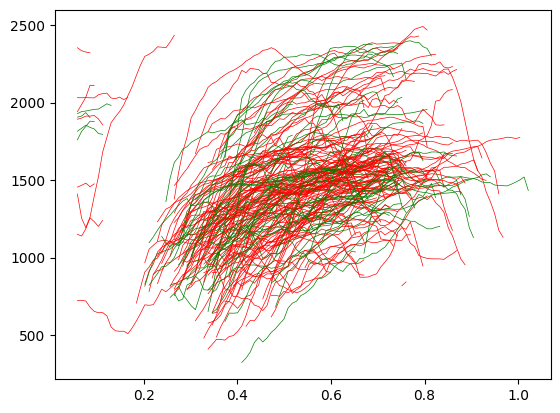

In [ ]:
import numpy as np
import pandas as pd
import math
from scipy import signal

ids = []
offsets = []
peak_norms = []
slope1 = []
slope2 = []
dists = []
dist_to_emb = []
init_size1 = []
init_size2 = []
avg_degree = []
max_size = []
q1_size = []
q2_size = []
q1_solidity = []
q2_solidity = []

appear_pn1 = []
appear_pn2 = []
dt_appear = []
fade_pn1 = []
fade_pn2 = []

target_list = []


for id_ in merged_df['embryo_id'].to_list():
        try:
            ids.append(id_)

            target_list.append(merged_df[merged_df['embryo_id']==id_]['y'].values[0])

        # for id_ in merged_df['embryo_id'].unique():
            # First PN: fill NaNs, compute time, extract active segment
            # group1 = group1.copy()
            group1 = full_pn1_df[full_pn1_df['embryo_id'] == id_].copy().reset_index(drop=True)
            group1['area'] = group1['area'].fillna(1)
            group1['time'] = group1['dt'].cumsum()
            start1, len1 = find_signal(group1['area'].values != 1)
            first_pn = group1.iloc[start1 : start1 + len1].reset_index(drop=True)

            # Second PN: same steps
            group2 = full_pn2_df[full_pn2_df['embryo_id'] == id_].copy().reset_index(drop=True)
            group2['area'] = group2['area'].fillna(1)
            group2['time'] = group2['dt'].cumsum()
            start2, len2 = find_signal(group2['area'].values != 1)
            second_pn = group2.iloc[start2 : start2 + len2].reset_index(drop=True)

            if first_pn.empty: 
                continue

            if second_pn.empty:
                continue

            whole_emb_slice = whole_emb_all_df.loc[whole_emb_all_df['embryo_id']==id_].iloc[start1 : start1 + len1]

           
           

            dx = first_pn['x'].values  - group2['x'].iloc[start1 : start1 + len1].values
            dy = first_pn['y'].values  - group2['y'].iloc[start1 : start1 + len1].values
            angle_rad = np.atan2(dy, dx)       # result in radians, ∈ (−π,π]
            angle_deg = np.degrees(angle_rad[~np.isnan(angle_rad)])


            max_size.append(first_pn['area'].max())
            q1_size.append(first_pn['area'].quantile(0.1))
            q2_size.append(first_pn['area'].quantile(0.9))
            

            eccentricity_to_embryo = np.sqrt(
                (first_pn['x'].values - whole_emb_slice['x'].values)**2 +
                (first_pn['y'].values - whole_emb_slice['y'].values)**2
            )
            
            
            dist = np.sqrt(
                (group1['x'].values - group2['x'].values)**2 +
                (group1['y'].values - group2['y'].values)**2
            )
        
            
            # Offset difference
            offset_diff = (start2 + len2) - (start1 + len1)
            if offset_diff != 0:
                # ids.append(id_)
                offsets.append(offset_diff)

            # Perimeter cross-correlation
            sig1 = first_pn['area']
            sig2 = second_pn['area']
            corr = signal.correlate(sig1, sig2)
            peak = corr.max()
            norm = np.linalg.norm(sig1) * np.linalg.norm(sig2)
            peak_norm = peak / norm if norm != 0 else 0
            

            # Area ratio (onl
            
            import statsmodels.api as sm
            mod = sm.OLS( first_pn['area'].values, first_pn['time'].values)
            res = mod.fit()
            
            slope1.append(res.params[0])
            dists.append(dist[~np.isnan(dist)].mean())


            mod = sm.OLS(second_pn['area'].values,second_pn['time'].values, )
            res = mod.fit()

            peak_norms.append(peak_norm)
            slope2.append(res.params[0])
            init_size1.append(first_pn['area'].iloc[:5].mean()/second_pn['area'].iloc[:5].mean())

            dist_to_emb.append(eccentricity_to_embryo[~np.isnan(eccentricity_to_embryo)].mean())

            appear_pn1.append(first_pn.iloc[0]['time'])
            appear_pn2.append(second_pn.iloc[0]['time'])

            dt_appear.append(second_pn.iloc[0]['time']-first_pn.iloc[0]['time'])

            fade_pn1.append(first_pn.iloc[-1]['time'])
            fade_pn2.append(second_pn.iloc[-1]['time'])
            avg_degree.append(np.quantile(angle_deg,0.1))

            smmoothen_pn1 = first_pn[['time','area']].rolling(12).mean()
            
            embryo_lbl = merged_df.loc[merged_df['embryo_id']==id_]['y'].values[0]

            plt.plot( smmoothen_pn1['time'].values,smmoothen_pn1['area'].values,color='red' if embryo_lbl==0 else 'green', lw=-.5)

        except Exception as e:
            print(e)
            continue

(array([ 1.,  0.,  0.,  2.,  5., 10., 10., 11.,  9.,  2.]),
 array([0.4547619 , 0.49857143, 0.54238095, 0.58619048, 0.63      ,
        0.67380952, 0.71761905, 0.76142857, 0.8052381 , 0.84904762,
        0.89285714]),
 <BarContainer object of 10 artists>)

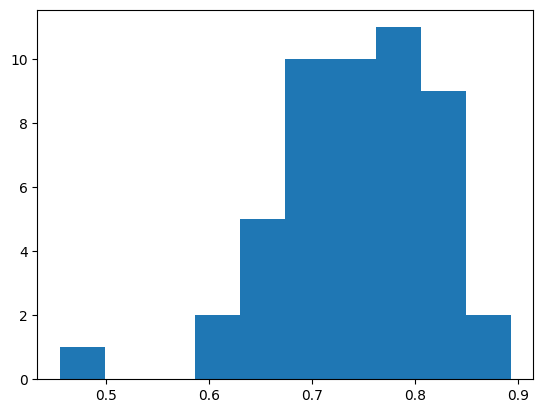

In [626]:
plt.hist(aucs)

In [ ]:
def sanitize_columns(df):
    df = df.copy()
    df.columns = df.columns.str.replace('"', '', regex=False)
    df.columns = df.columns.str.replace("'", '', regex=False)
    df.columns = df.columns.str.replace(":", '_', regex=False)
    df.columns = df.columns.str.replace(',', '_', regex=False)
    df.columns = df.columns.str.replace('[^0-9a-zA-Z_]', '_', regex=True)
    return df

c = sanitize_columns(X)


In [683]:
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np

# ---- 1. Split into train/held-out test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sanitized, y, test_size=0.2, stratify=y, random_state=420
)

# ---- 2. CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = LGBMClassifier(verbose=-1,)

# ---- 3. Train on CV folds & collect AUCs
auc_cv_scores = cross_val_score(model, X_trainval, y_trainval, cv=cv, scoring="roc_auc")
print(f"Mean CV AUC: {auc_cv_scores.mean():.4f} ± {auc_cv_scores.std():.4f}")

# ---- 4. Fit model to full training set & compute permutation importance
model.fit(X_trainval, y_trainval)
result = permutation_importance(model, X_trainval, y_trainval, scoring="roc_auc", n_repeats=10, random_state=42)

# ---- 5. Select top-k most important features
top_k_features = 150 # change if needed
importances = pd.Series(result.importances_mean, index=X_sanitized.columns)
selected_features = importances.sort_values(ascending=False).head(top_k_features).index.tolist()
print(f"Selected {len(selected_features)} features.")

# ---- 6. Retrain on full training set with selected features
model_final = LGBMClassifier(verbose=-1,)
model_final.fit(X_trainval[selected_features], y_trainval)

# ---- 7. Evaluate on held-out test set
y_pred_test = model_final.predict_proba(X_test[selected_features])[:, 1]
test_auc = roc_auc_score(y_test, y_pred_test)
print(f"Test AUC (held-out): {test_auc:.4f}")


Mean CV AUC: 0.7800 ± 0.0583
Selected 150 features.
Test AUC (held-out): 0.4310


In [682]:
auc_cv_scores

array([0.77898551, 0.85507246, 0.69318182, 0.82954545, 0.743083  ])

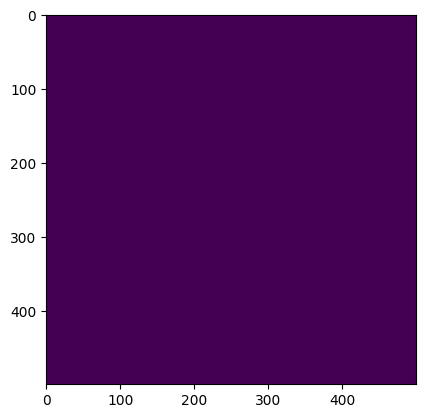

In [609]:
import matplotlib.pyplot as plt
plt.imshow(masks[83][1])